In [34]:
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/0930.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

/var/folders/r0/h30ywvr55x98xwjf49klh76m0000gp/T/ipykernel_54456/559344678.py:4: DtypeWarning: Columns (95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="utf-8")


In [6]:
import pandas as pd
import numpy as np
import joblib

load_path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/"

# 1) 알림 메타정보
X_alerts = pd.read_csv(load_path + "1001alerts_with_X.csvX_alerts.csv")

# 2) SHAP 행렬 (raw positive-only)
shap_pos_clipped = np.load(load_path + "1001alerts_with_X.csv1001shap_pos_clipped.npy")

# 3) SHAP 행렬 (scaled)
X_scaled = np.load(load_path + "1001alerts_with_X.csv1001X_scaled.npy")

# 4) Feature 이름
FEATURES = joblib.load(load_path + "1001alerts_with_X.csvFEATURES.pkl")

# 확인
print("불러오기 완료!")
print("X_alerts shape:", X_alerts.shape)           
print("shap_pos_clipped shape:", shap_pos_clipped.shape)  
print("X_scaled shape:", X_scaled.shape)           
print("FEATURES 개수:", len(FEATURES))
print("예시 FEATURES:", FEATURES[:10])



불러오기 완료!
X_alerts shape: (634, 6)
shap_pos_clipped shape: (634, 79)
X_scaled shape: (634, 79)
FEATURES 개수: 79
예시 FEATURES: ['15m_G_Diff_5', '15m_G_Diff_6', '15m_G_Diff_7', '15m_G_Diff_8', '15m_G_Diff_9', '15m_G_Diff_10', 'Z_Previous_5', 'Z_Previous_6', 'Z_Previous_7', 'Z_Previous_8']


In [44]:
# 1) Timestamp 포맷 맞추기
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
X_alerts["ts"] = pd.to_datetime(X_alerts["ts"], errors="coerce")

# 2) FEATURES + StudyID + Timestamp 선택
df_features = df[["StudyID", "Timestamp"] + FEATURES].copy()

# 3) alerts와 merge
df_alerts_raw = pd.merge(
    X_alerts,
    df_features,
    left_on=["StudyID", "ts"],
    right_on=["StudyID", "Timestamp"],
    how="left"
)

# 4) 클러스터 라벨 붙이기
df_alerts_raw["Cluster"] = clusters


df_alerts_raw shape: (634, 87)
   StudyID                  ts        date  y_true_at_alert  y_prob_at_alert  \
0        1 2022-10-13 18:42:00  2022-10-13                1         0.714333   
1        1 2022-10-13 20:57:00  2022-10-13                0         0.635162   
2        1 2022-10-14 15:57:00  2022-10-14                1         0.731867   
3        1 2022-10-14 18:57:00  2022-10-14                0         0.622380   
4        1 2022-10-14 20:42:00  2022-10-14                0         0.461395   

   success           Timestamp  15m_G_Diff_5  15m_G_Diff_6  15m_G_Diff_7  ...  \
0        1 2022-10-13 18:42:00          -6.0           4.0           6.0  ...   
1        0 2022-10-13 20:57:00          -4.0           1.0           5.0  ...   
2        1 2022-10-14 15:57:00          -7.0          -2.0           6.0  ...   
3        0 2022-10-14 18:57:00           1.0          -3.0          -7.0  ...   
4        0 2022-10-14 20:42:00           1.0          -2.0           0.0  ...   

 

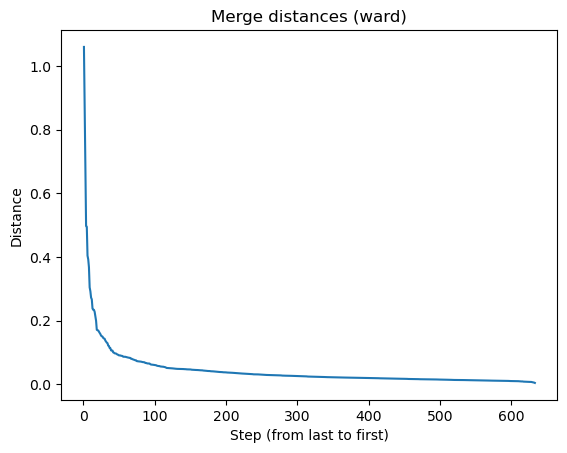

Natural cut point suggests ~3 clusters
{1: 63, 2: 174, 3: 397}


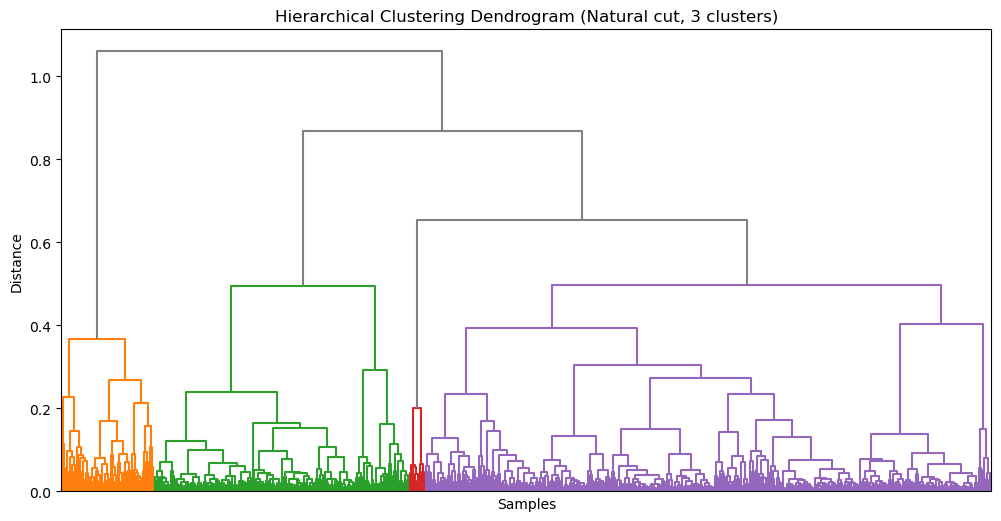

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# === 1) SHAP scaled 행렬 사용 ===
X_raw = shap_pos_clipped   # or X_scaled (둘 중 하나 선택)
# X_scaled: 이미 StandardScaler 적용됨

# === 2) linkage 계산 ===
Z = linkage(X_raw, method="ward")

# === 3) 병합 거리 확인 ===
distances = Z[:, 2]  # 세 번째 열이 병합 거리
plt.plot(range(1, len(distances)+1), distances[::-1])
plt.title("Merge distances (ward)")
plt.xlabel("Step (from last to first)")
plt.ylabel("Distance")
plt.show()

# === 4) 자연스러운 컷 포인트 찾기 ===
diffs = np.diff(distances)
cut_idx = np.argmax(diffs)
n_clusters = len(distances) - cut_idx
print(f"Natural cut point suggests ~{n_clusters} clusters")

# === 5) 해당 컷 포인트로 클러스터링 ===
clusters = fcluster(Z, t=distances[cut_idx], criterion="distance")

# === 6) 결과 확인 ===
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))

# === 7) 덴도그램 시각화 ===
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    color_threshold=distances[cut_idx],
    above_threshold_color="gray",
    no_labels=True
)
plt.title(f"Hierarchical Clustering Dendrogram (Natural cut, {n_clusters} clusters)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# === 8) 클러스터 라벨을 X_alerts 메타데이터에 붙이기 ===
X_with_cluster = X_alerts.copy()
X_with_cluster["Cluster"] = clusters


# Joint plot

In [16]:
import numpy as np
import pandas as pd

# === 클러스터별 평균 SHAP 절대값 계산 ===
cluster_shap_mean = {}
for clust in np.unique(X_with_cluster["Cluster"]):
    idx = X_with_cluster["Cluster"] == clust
    cluster_shap_mean[clust] = np.abs(shap_pos_clipped[idx]).mean(axis=0)

# === 클러스터별 Top 5 feature 뽑기 ===
top_feats = {}
for clust, shap_vals in cluster_shap_mean.items():
    top_idx = np.argsort(shap_vals)[::-1][:5]   # 상위 5개 인덱스
    top_feats[clust] = [FEATURES[i] for i in top_idx]

print("클러스터별 Top5 feature:")
for c, feats in top_feats.items():
    print(f"Cluster {c}: {feats}")


클러스터별 Top5 feature:
Cluster 1: ['hungry', 'mean_intensity_1h', 'hungry_within', 'Time_24h', 'How_tired']
Cluster 2: ['Z_Previous_4', 'Time_24h', 'mean_intensity_1h', 'G_minus_T_pre_1.5h', 'How_anxious_within']
Cluster 3: ['mean_intensity_1h', 'Time_24h', 'hungry', 'hungry_within', 'TimeInBed']


In [62]:
# ts를 datetime으로 변환 후 시각을 float으로
df_alerts_raw["ts"] = pd.to_datetime(df_alerts_raw["ts"], errors="coerce")
df_alerts_raw["Time_24h"] = df_alerts_raw["ts"].dt.hour + df_alerts_raw["ts"].dt.minute / 60



=== Top5 features from Cluster 1 ===
Plotting hungry vs mean_intensity_1h


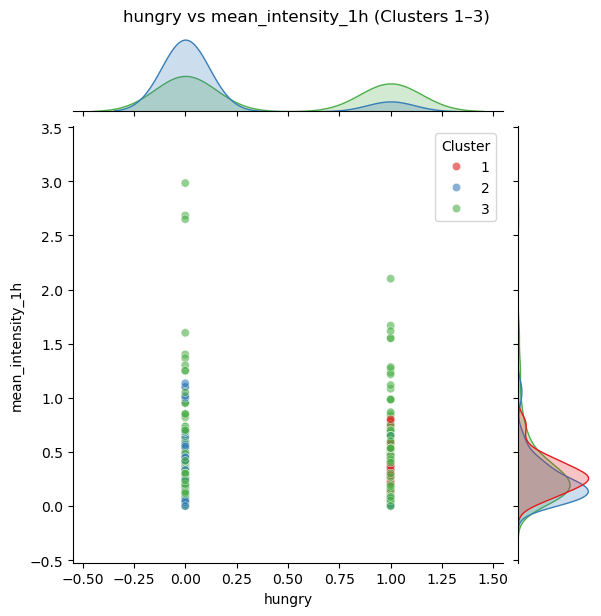

Plotting hungry vs hungry_within


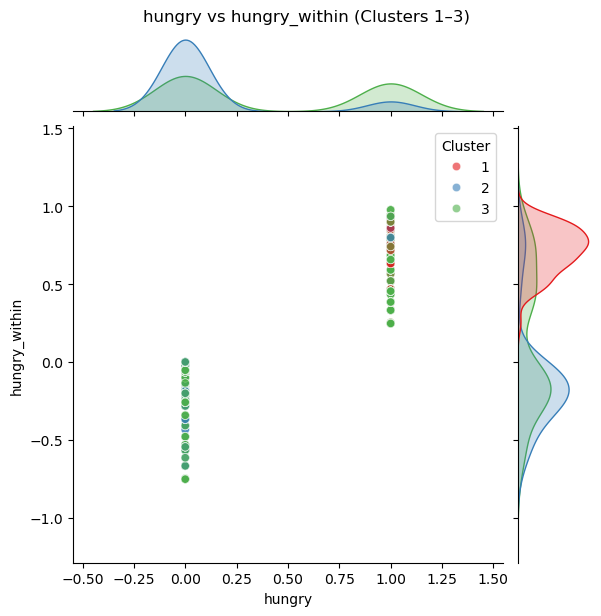

Plotting hungry vs Time_24h


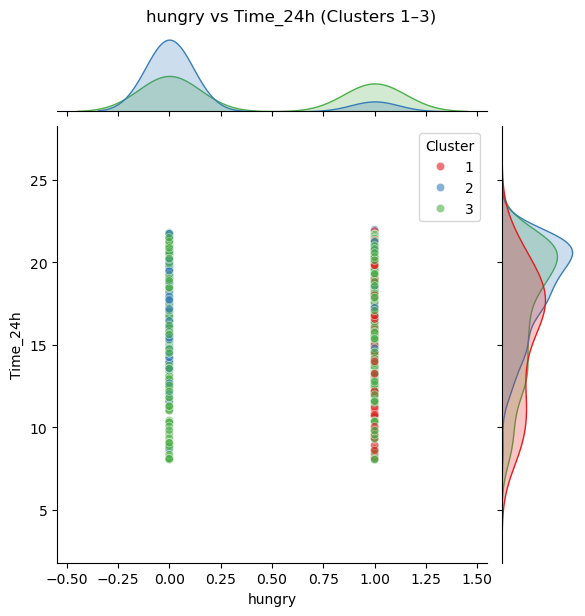

Plotting hungry vs How_tired


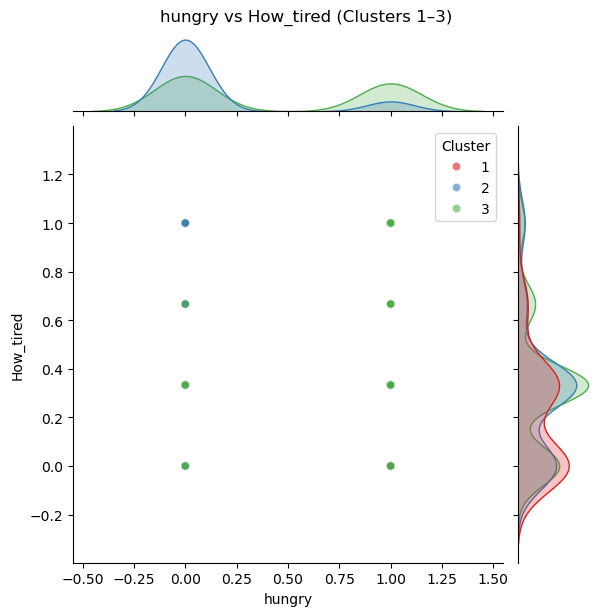

Plotting mean_intensity_1h vs hungry_within


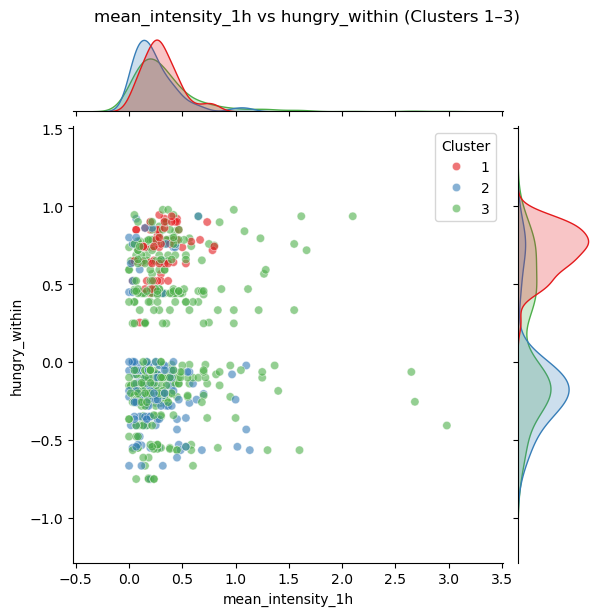

Plotting mean_intensity_1h vs Time_24h


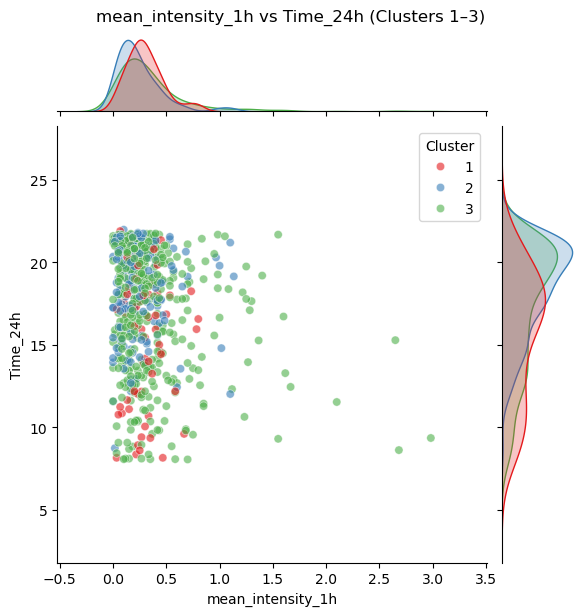

Plotting mean_intensity_1h vs How_tired


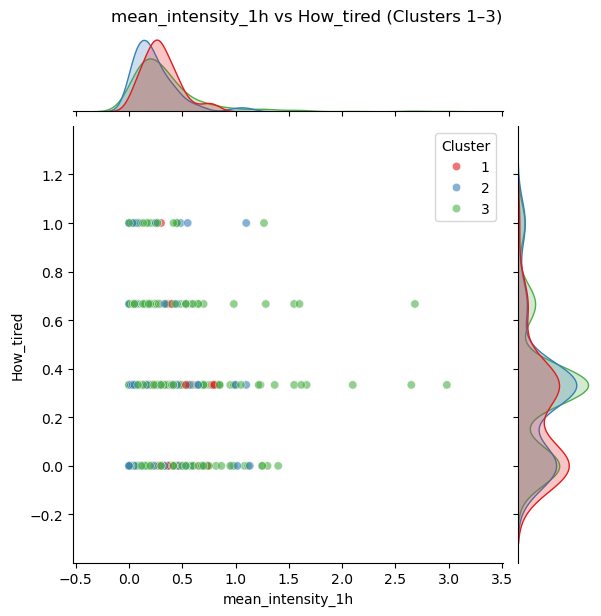

Plotting hungry_within vs Time_24h


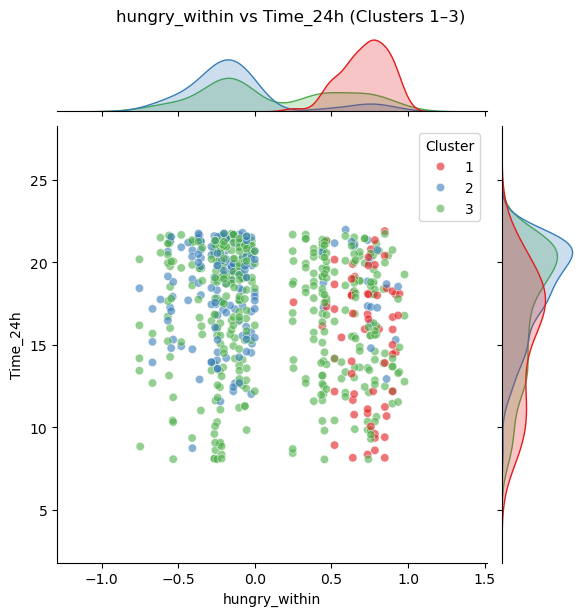

Plotting hungry_within vs How_tired


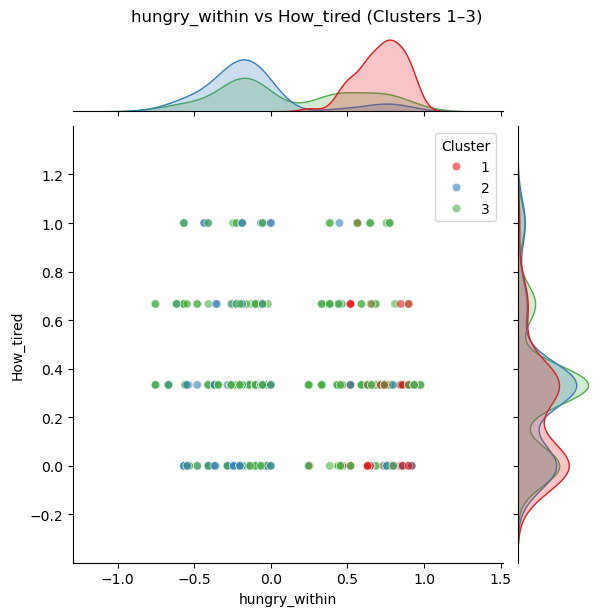

Plotting Time_24h vs How_tired


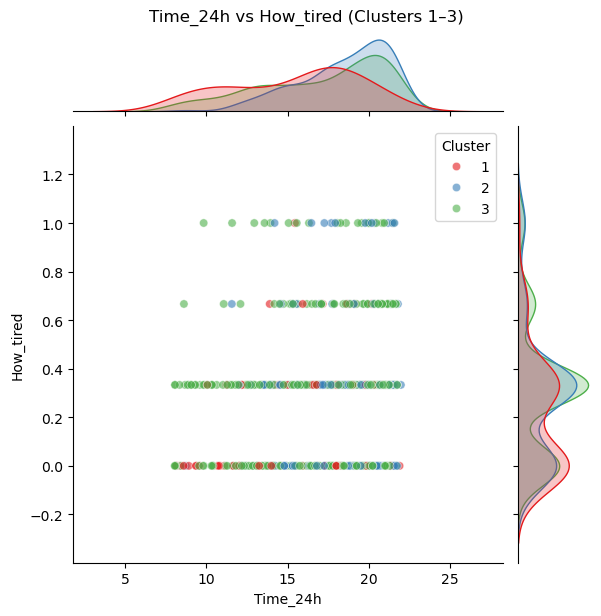


=== Top5 features from Cluster 2 ===
Plotting Z_Previous_4 vs Time_24h


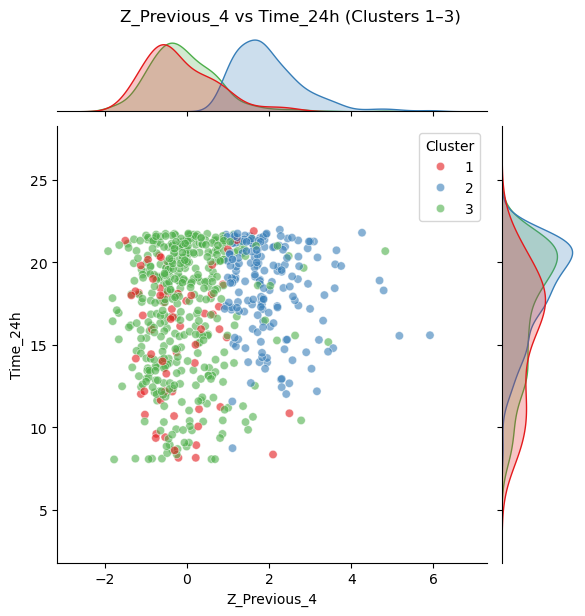

Plotting Z_Previous_4 vs mean_intensity_1h


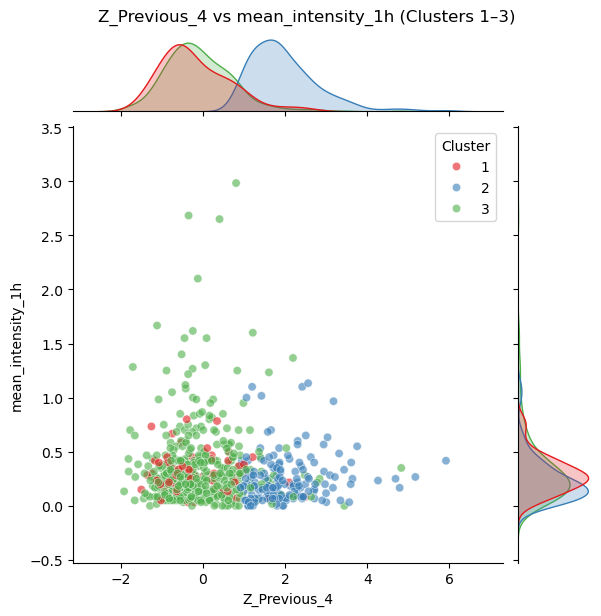

Plotting Z_Previous_4 vs G_minus_T_pre_1.5h


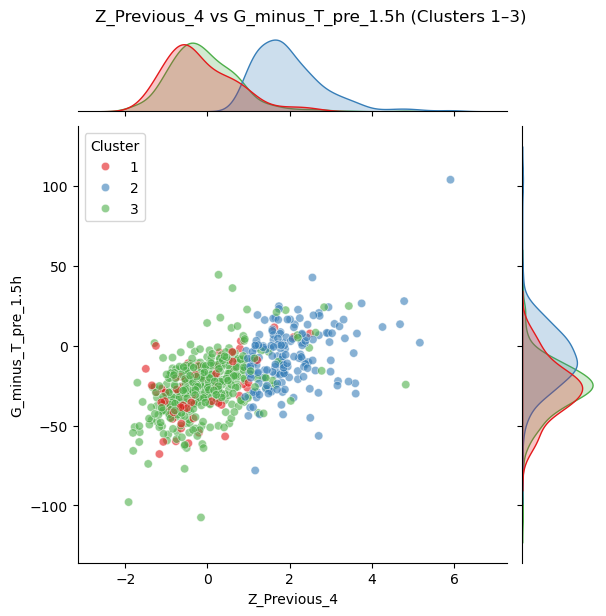

Plotting Z_Previous_4 vs How_anxious_within


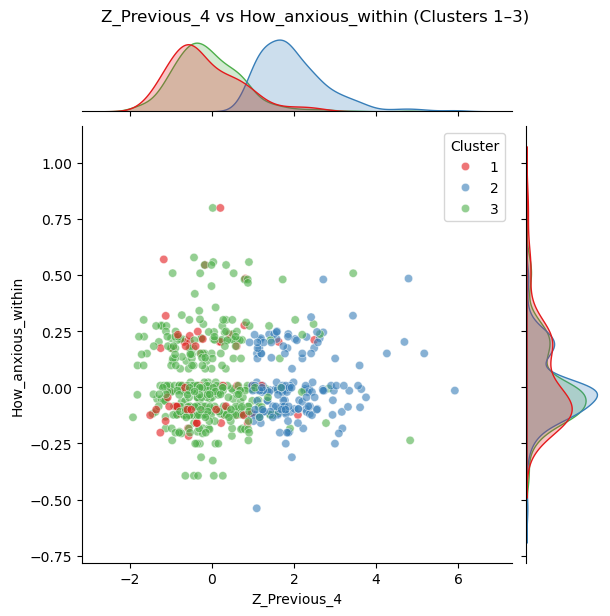

Plotting Time_24h vs mean_intensity_1h


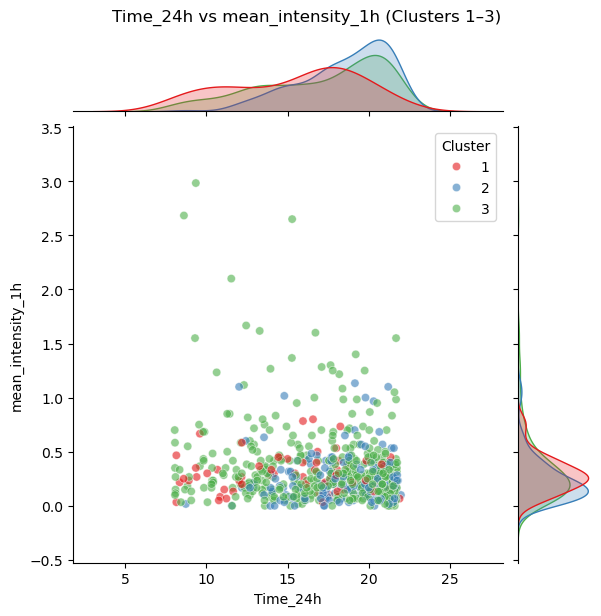

Plotting Time_24h vs G_minus_T_pre_1.5h


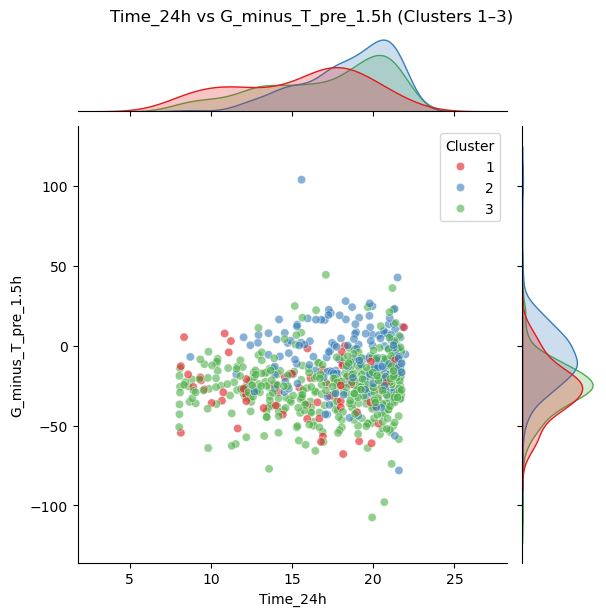

Plotting Time_24h vs How_anxious_within


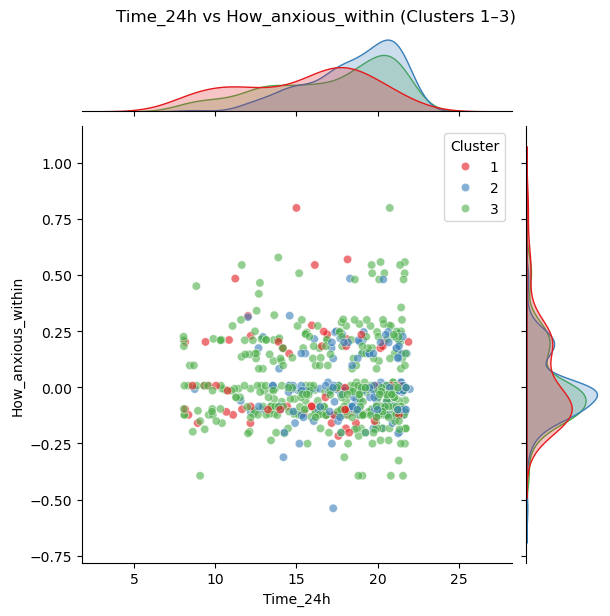

Plotting mean_intensity_1h vs G_minus_T_pre_1.5h


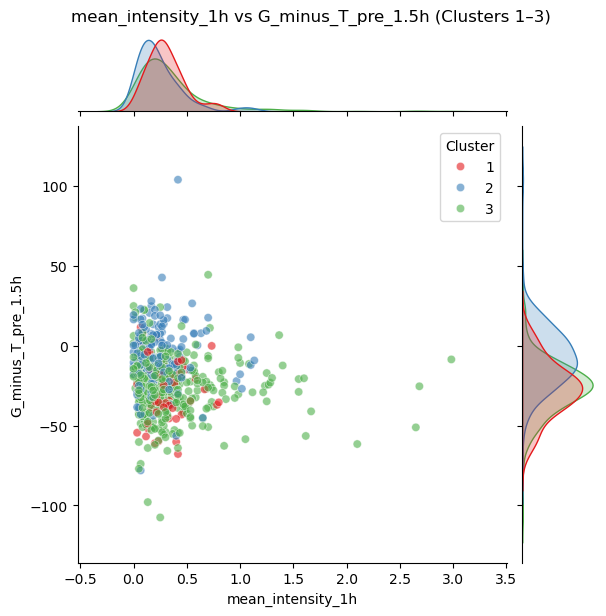

Plotting mean_intensity_1h vs How_anxious_within


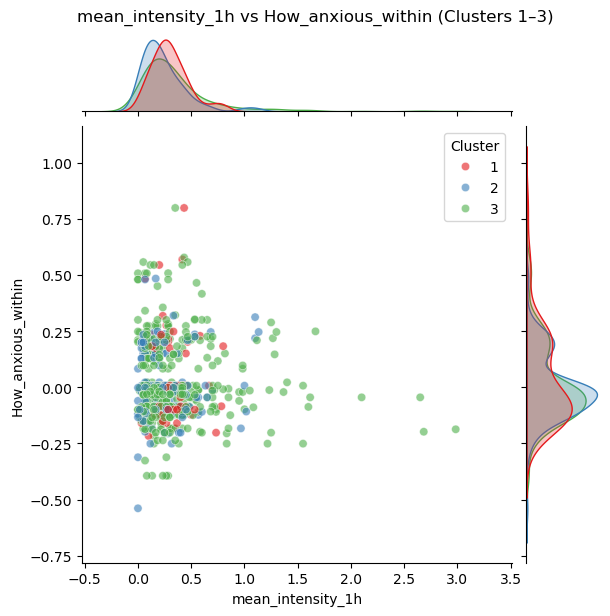

Plotting G_minus_T_pre_1.5h vs How_anxious_within


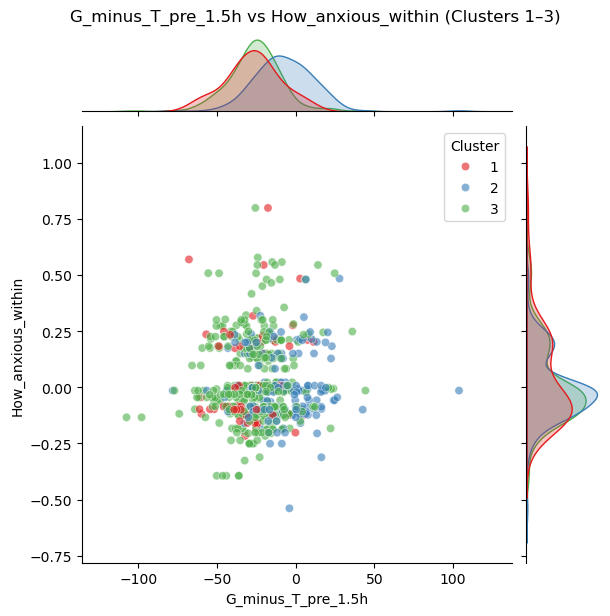


=== Top5 features from Cluster 3 ===
Plotting mean_intensity_1h vs Time_24h


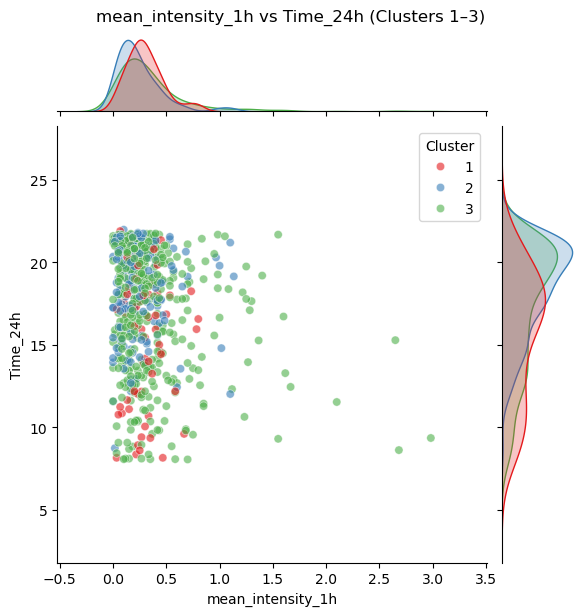

Plotting mean_intensity_1h vs hungry


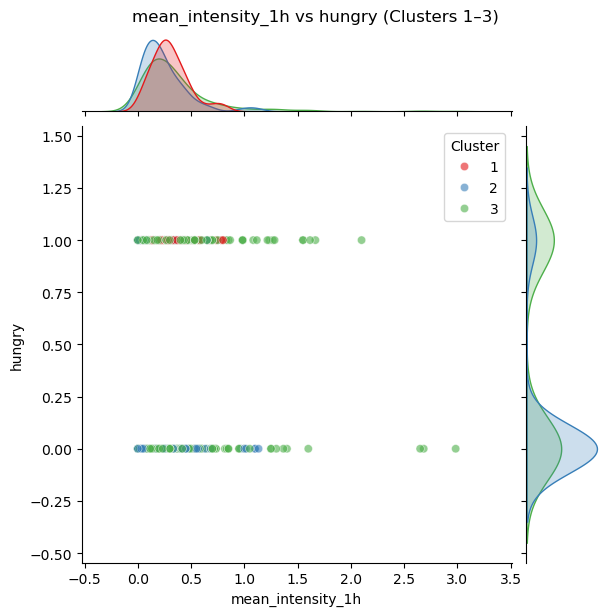

Plotting mean_intensity_1h vs hungry_within


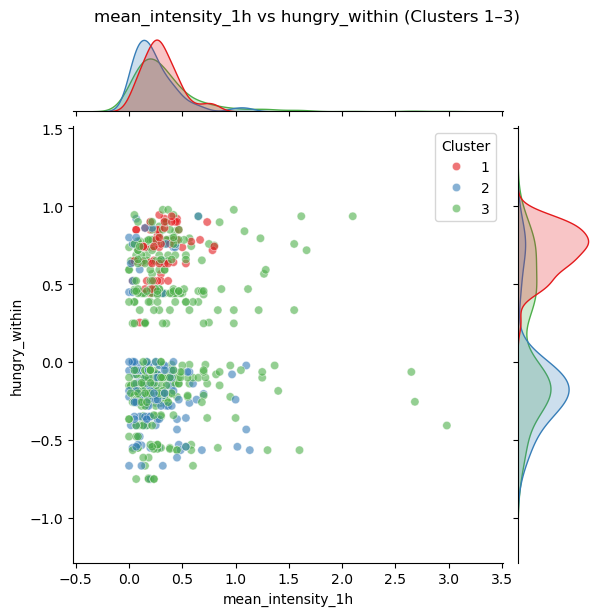

Plotting mean_intensity_1h vs TimeInBed


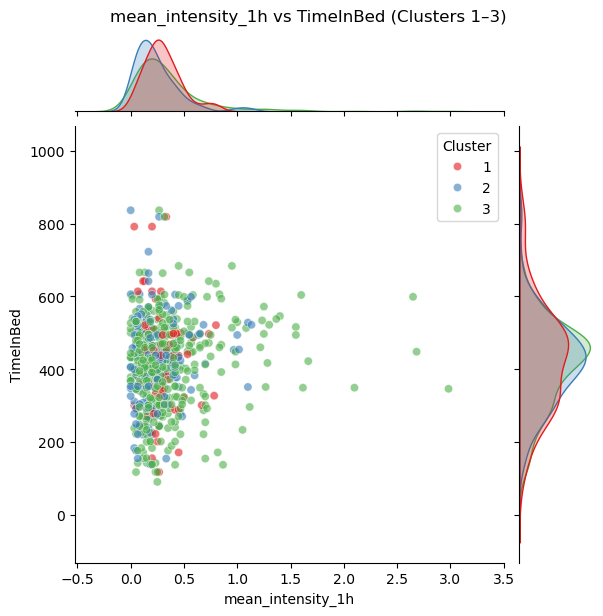

Plotting Time_24h vs hungry


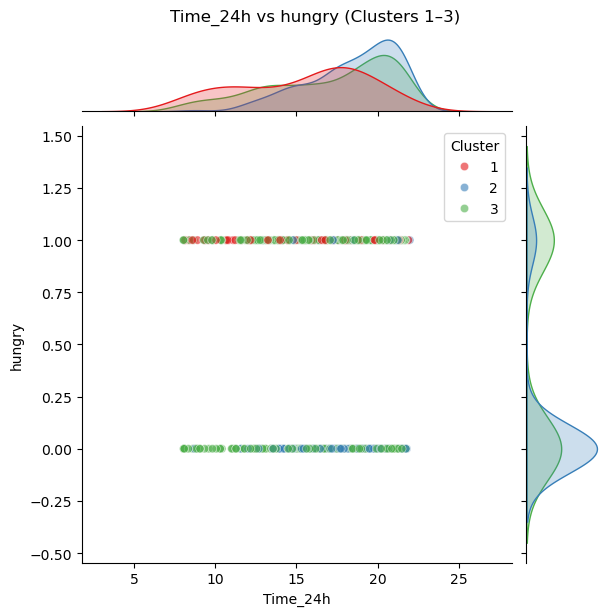

Plotting Time_24h vs hungry_within


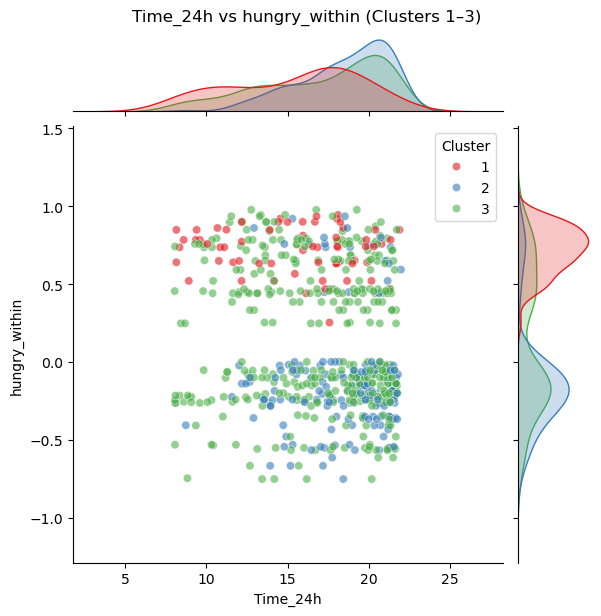

Plotting Time_24h vs TimeInBed


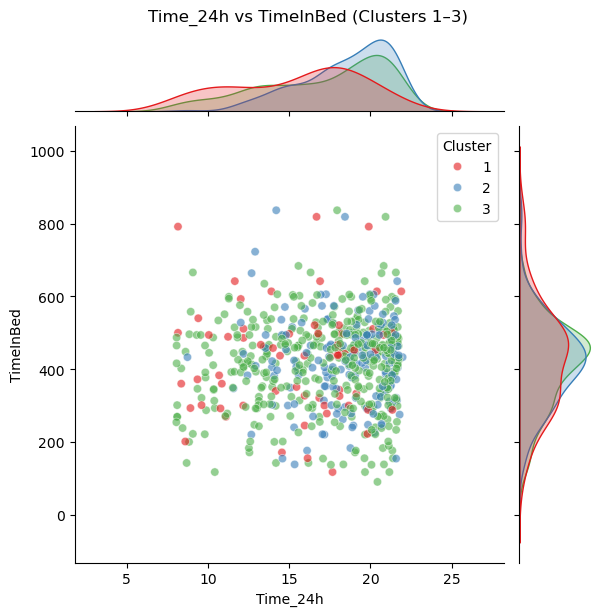

Plotting hungry vs hungry_within


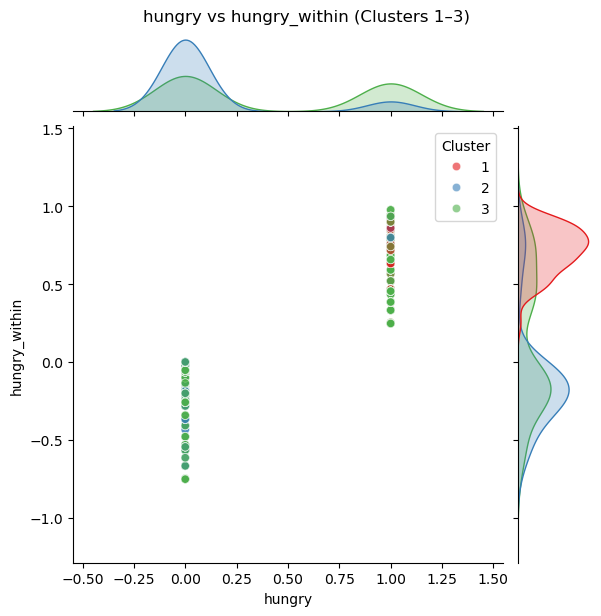

Plotting hungry vs TimeInBed


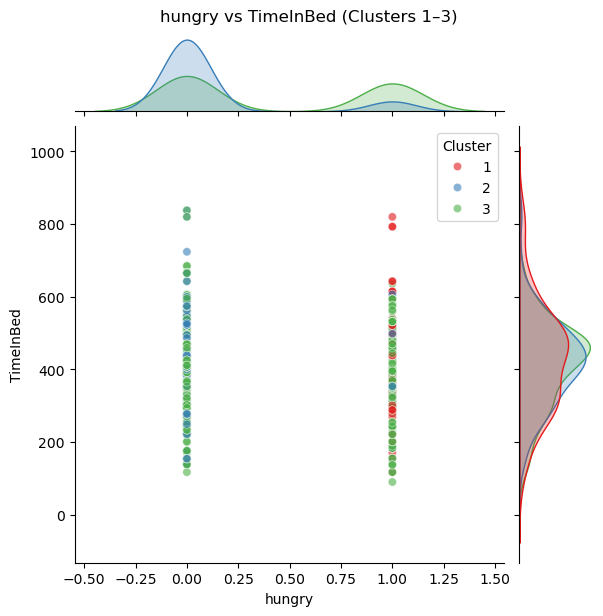

Plotting hungry_within vs TimeInBed


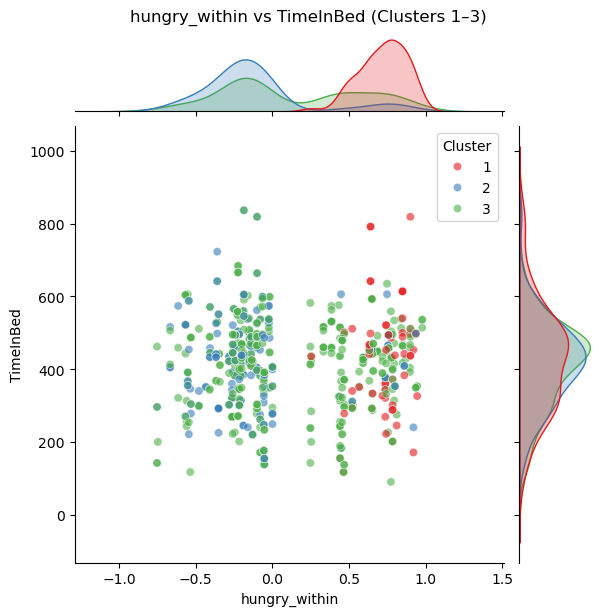

In [64]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# === Top5 feature ===
top_feats = {
    1: ['hungry', 'mean_intensity_1h', 'hungry_within', 'Time_24h', 'How_tired'],
    2: ['Z_Previous_4', 'Time_24h', 'mean_intensity_1h', 'G_minus_T_pre_1.5h', 'How_anxious_within'],
    3: ['mean_intensity_1h', 'Time_24h', 'hungry', 'hungry_within', 'TimeInBed']
}

# FEATURES 전부 numeric 변환
for col in FEATURES:
    df_alerts_raw[col] = pd.to_numeric(df_alerts_raw[col], errors="coerce")

# === Top5  (2) ===
for clust, feats in top_feats.items():
    print(f"\n=== Top5 features from Cluster {clust} ===")
    
    for f1, f2 in itertools.combinations(feats, 2):
        print(f"Plotting {f1} vs {f2}")
        g = sns.jointplot(
            data=df_alerts_raw,
            x=f1, y=f2,
            hue="Cluster",                   # 
            palette="Set1",
            alpha=0.6,
            kind="scatter",                  # 🔑 scatter 강제
            marginal_kws=dict(common_norm=False, fill=True)
        )
        g.fig.suptitle(f"{f1} vs {f2} (Clusters 1–3)", y=1.02)
        plt.show()


# Center value at each cluster

In [67]:
import numpy as np
import pandas as pd

cluster_centers = {}
central_indices = {}

for cl in np.unique(X_with_cluster["Cluster"]):
    idxs = np.where(X_with_cluster["Cluster"] == cl)[0]
    cluster_data = X_scaled[idxs]

    # Mean center
    center = cluster_data.mean(axis=0)
    cluster_centers[cl] = center

    # Top 5 centered index
    dists = np.linalg.norm(cluster_data - center, axis=1)
    closest_idx = idxs[np.argsort(dists)[:5]]
    central_indices[cl] = closest_idx

print(central_indices)


{1: array([578, 241, 497, 105, 569]), 2: array([ 83, 534, 426, 531, 138]), 3: array([316, 352, 161, 186, 629])}


Plotting Z_Previous_4 vs Time_24h


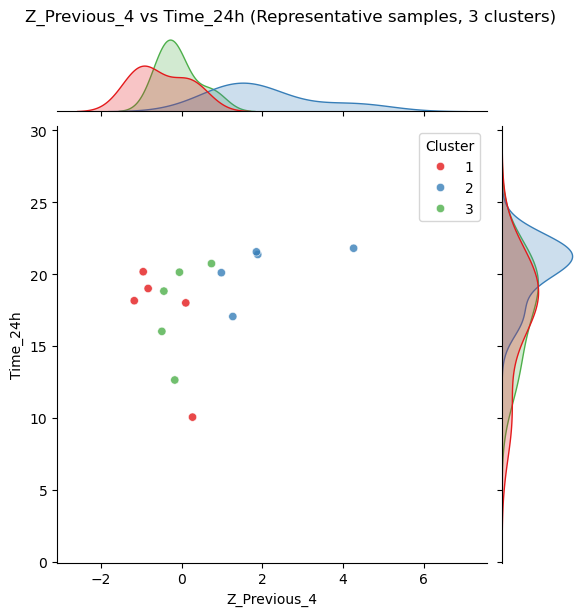

Plotting Z_Previous_4 vs How_anxious_within


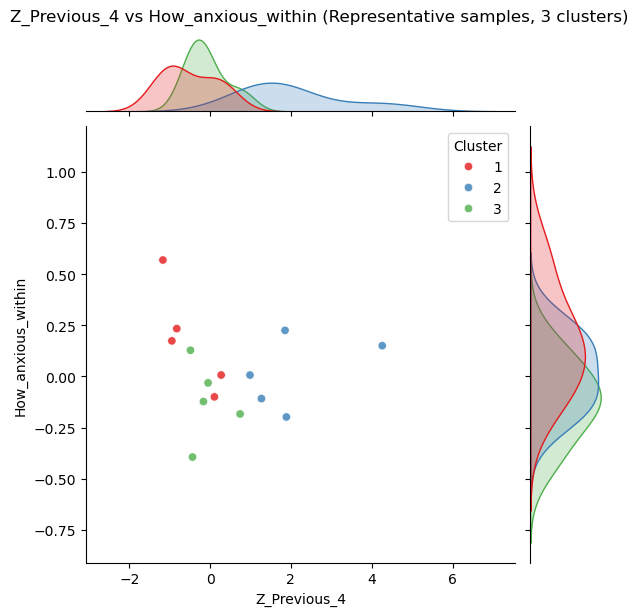

Plotting Z_Previous_4 vs TimeInBed


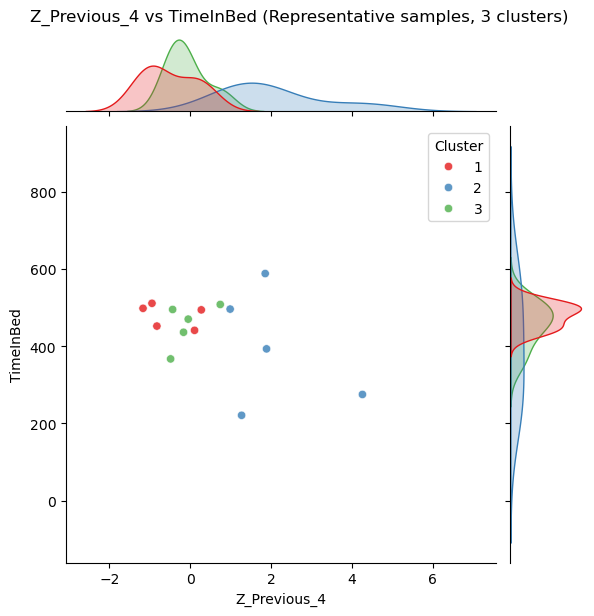

Plotting Z_Previous_4 vs mean_intensity_1h


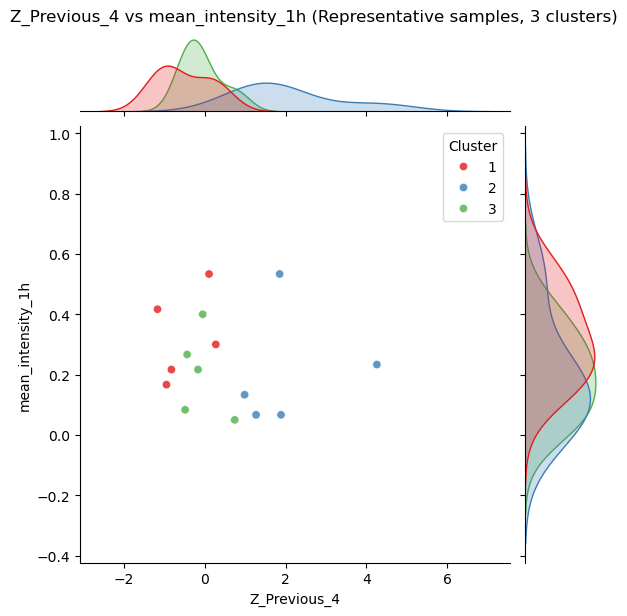

Plotting Z_Previous_4 vs hungry_within


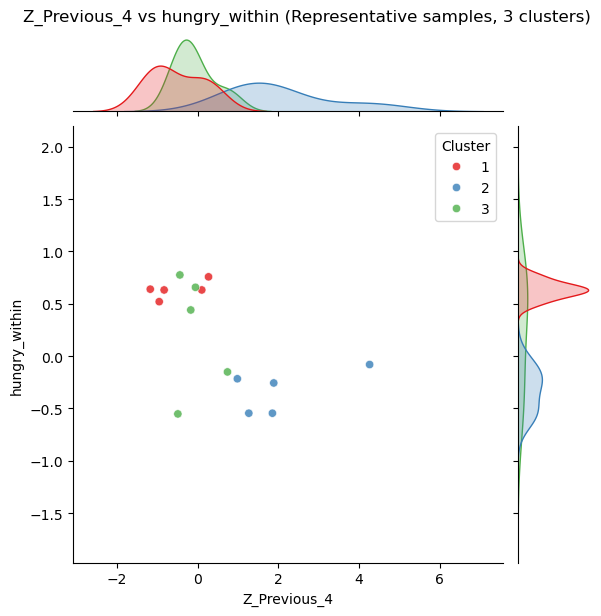

Plotting Z_Previous_4 vs How_tired


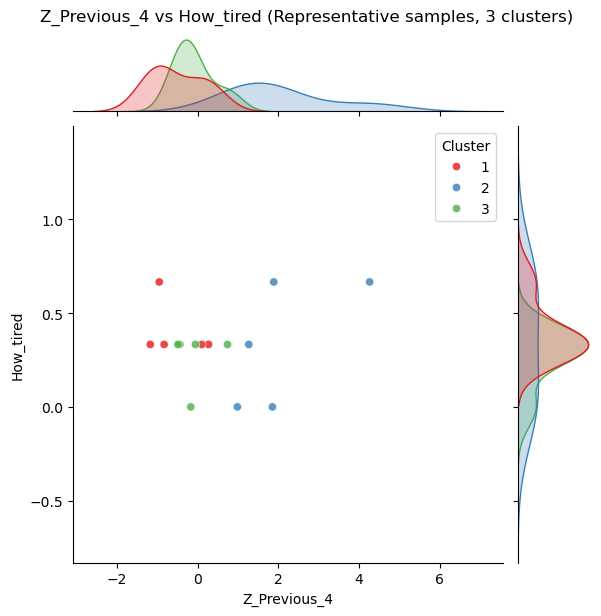

Plotting Z_Previous_4 vs G_minus_T_pre_1.5h


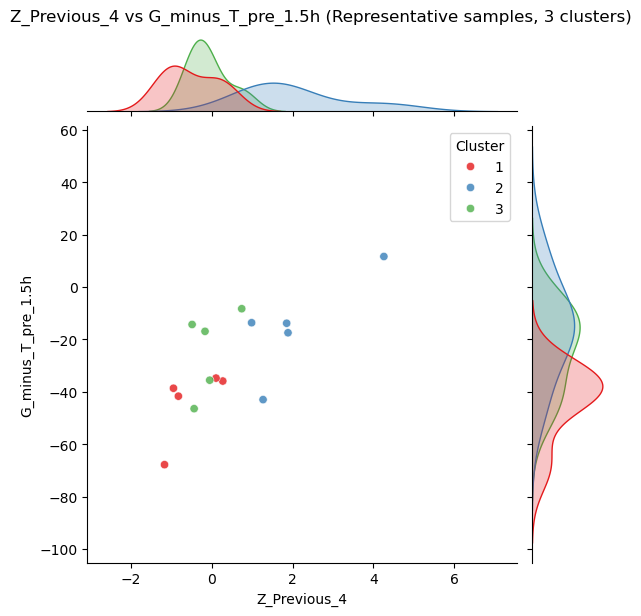

Plotting Z_Previous_4 vs hungry


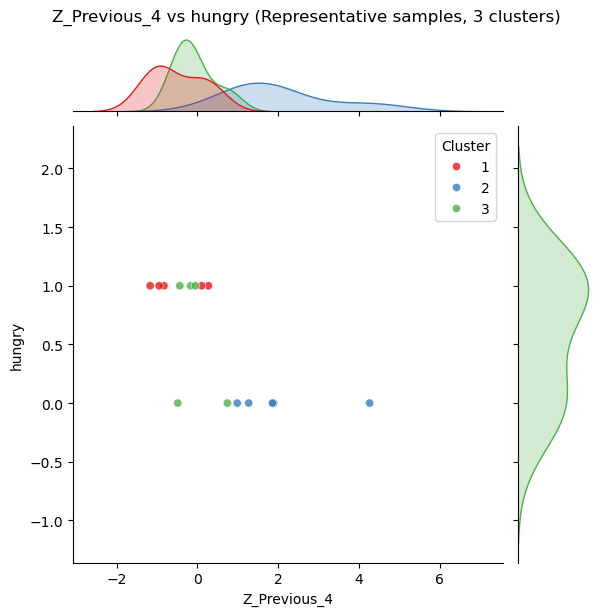

Plotting Time_24h vs How_anxious_within


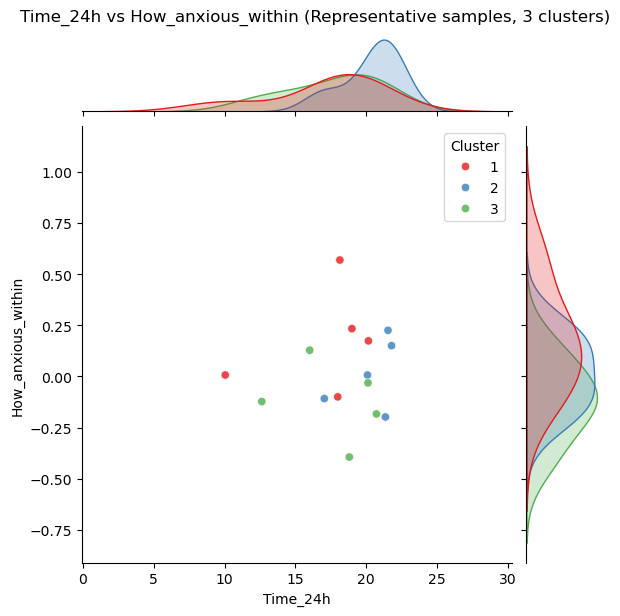

Plotting Time_24h vs TimeInBed


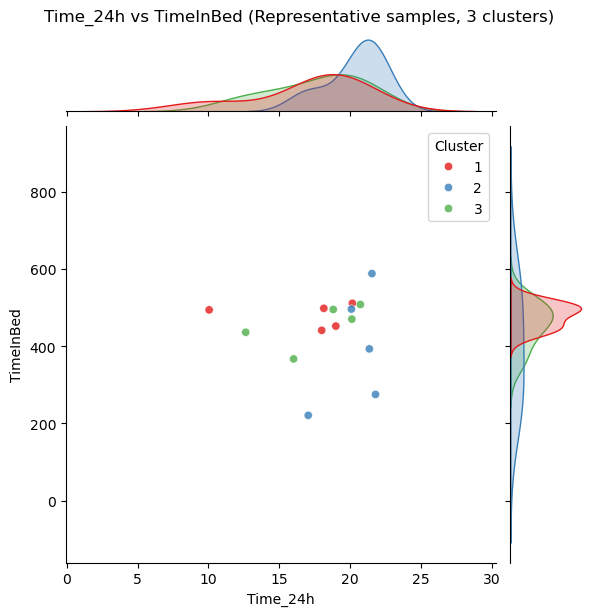

Plotting Time_24h vs mean_intensity_1h


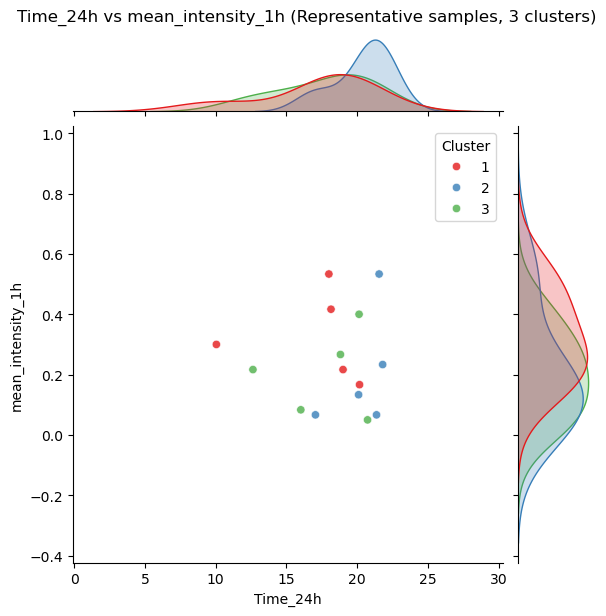

Plotting Time_24h vs hungry_within


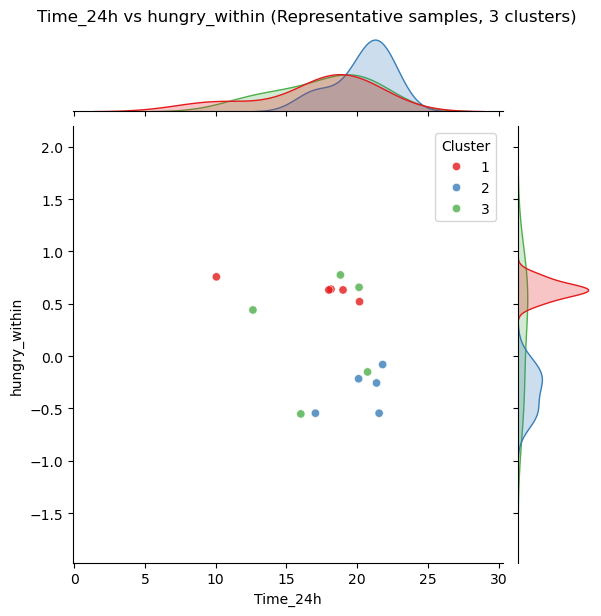

Plotting Time_24h vs How_tired


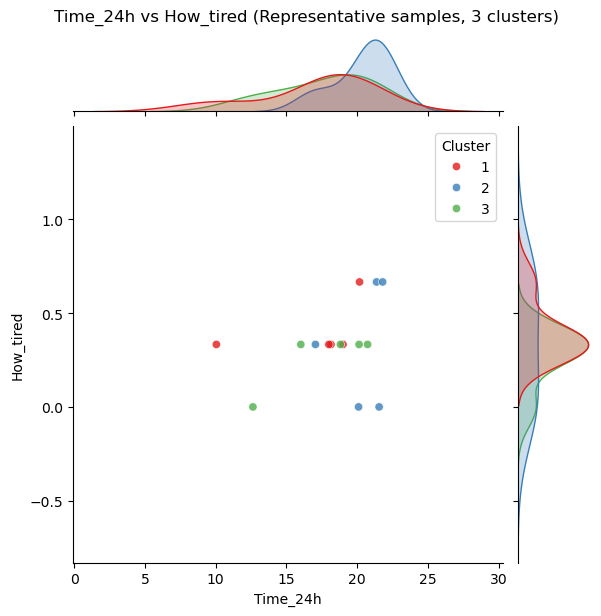

Plotting Time_24h vs G_minus_T_pre_1.5h


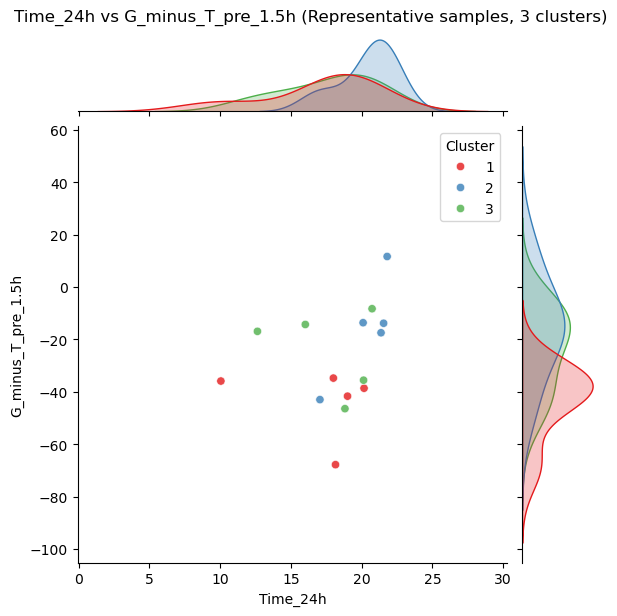

Plotting Time_24h vs hungry


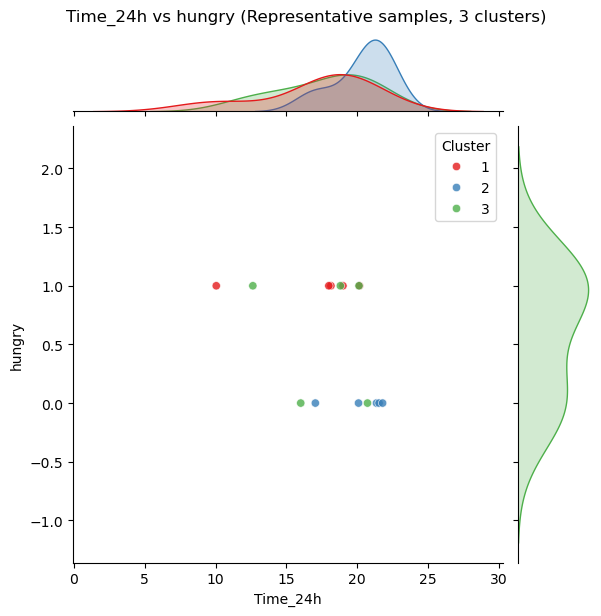

Plotting How_anxious_within vs TimeInBed


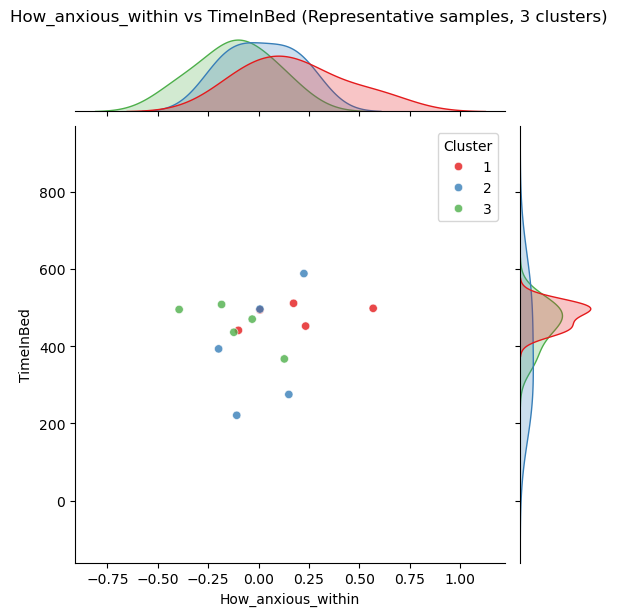

Plotting How_anxious_within vs mean_intensity_1h


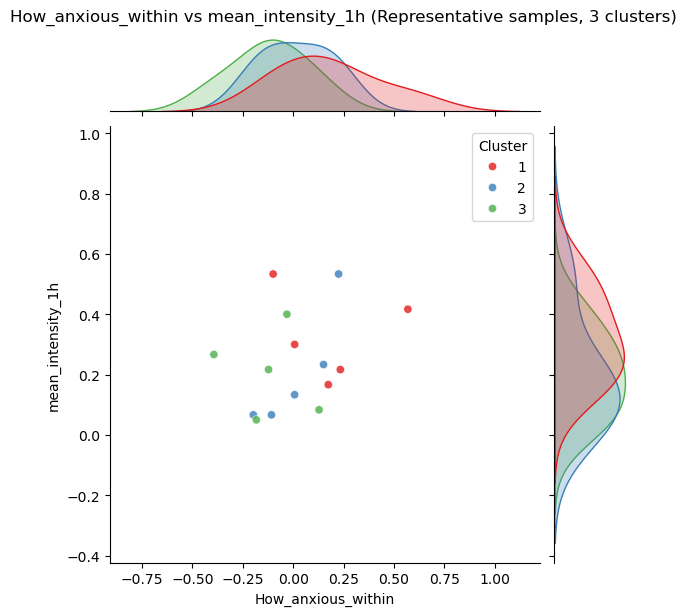

Plotting How_anxious_within vs hungry_within


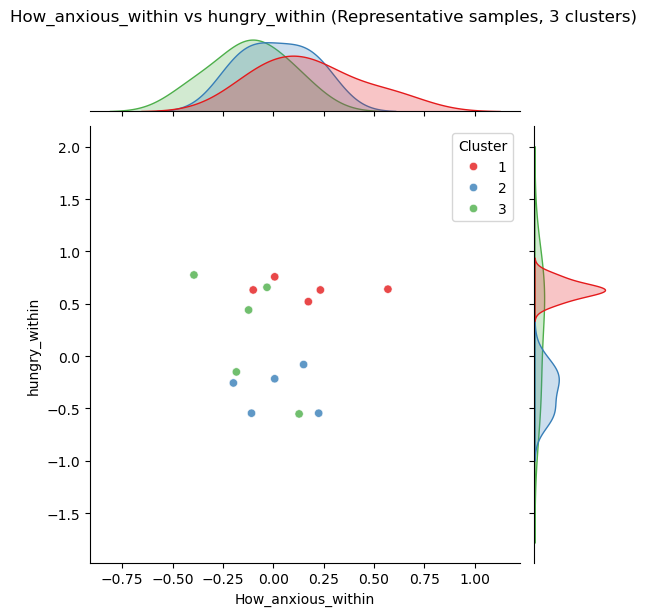

Plotting How_anxious_within vs How_tired


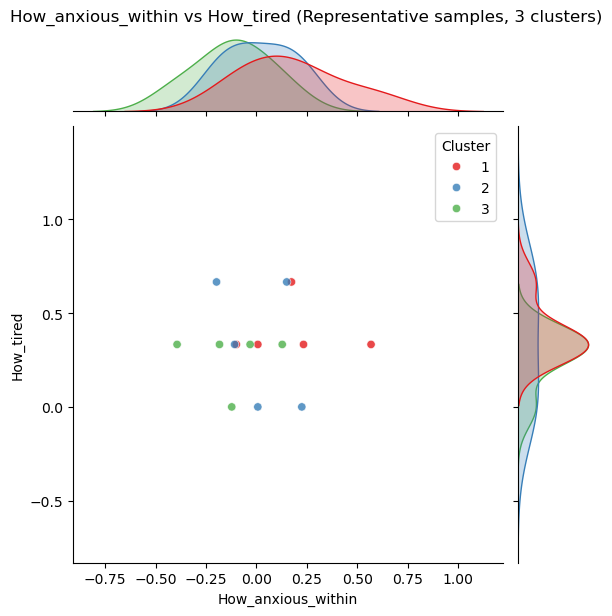

Plotting How_anxious_within vs G_minus_T_pre_1.5h


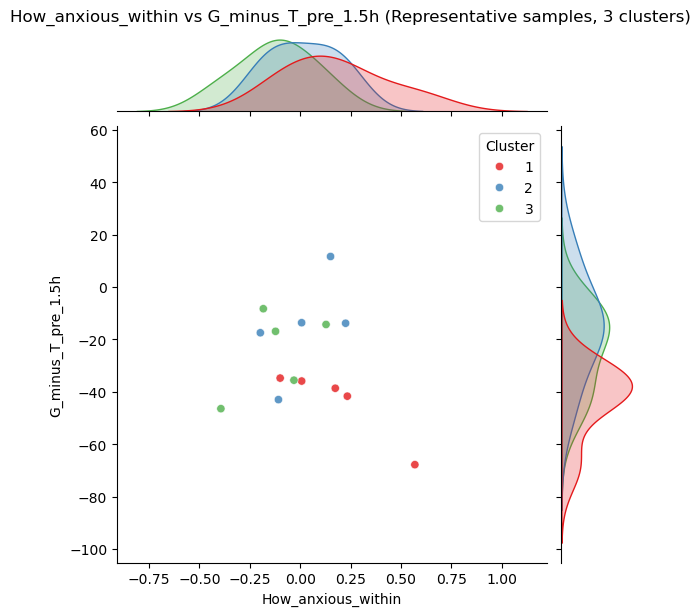

Plotting How_anxious_within vs hungry


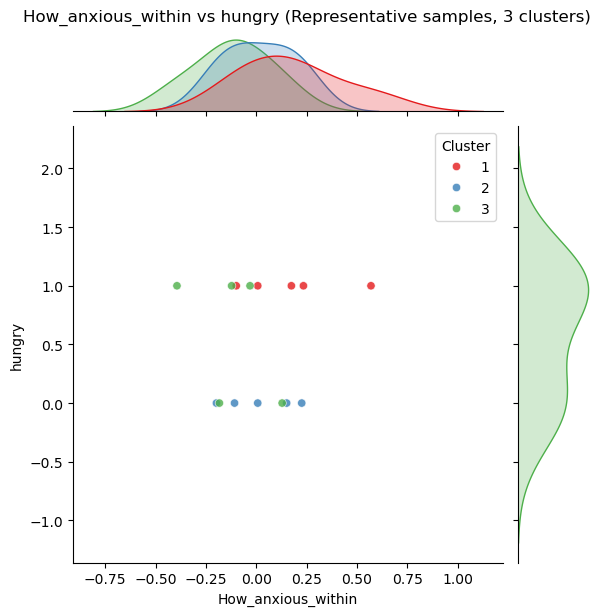

Plotting TimeInBed vs mean_intensity_1h


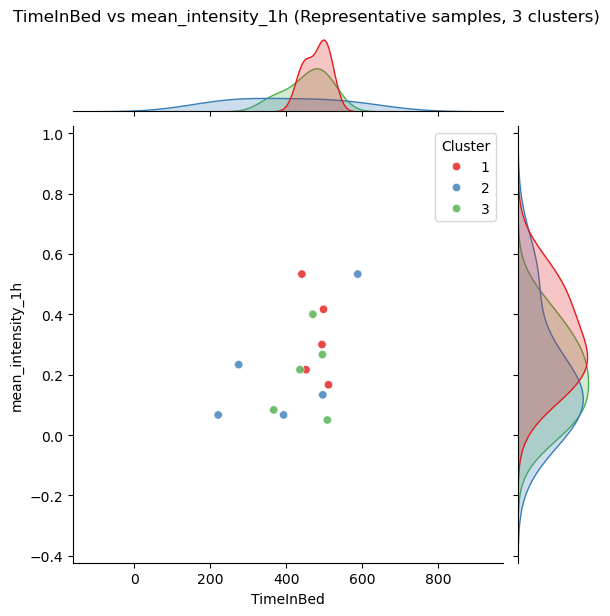

Plotting TimeInBed vs hungry_within


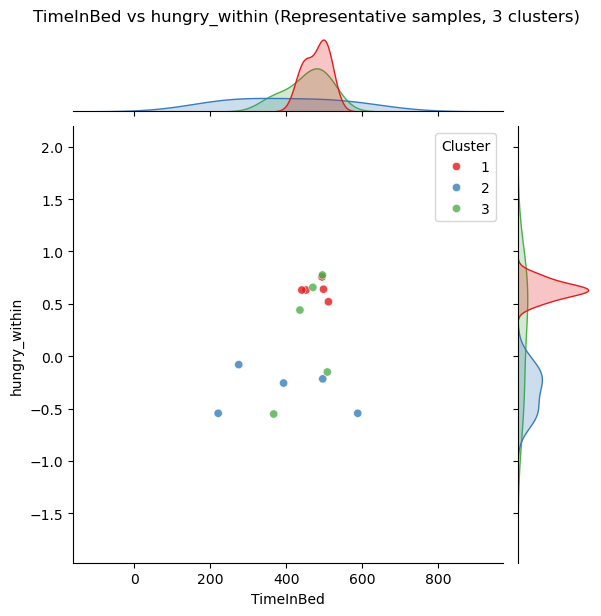

Plotting TimeInBed vs How_tired


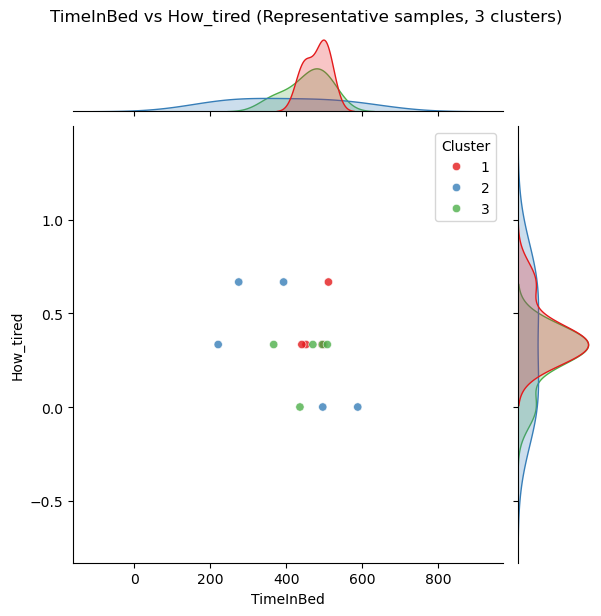

Plotting TimeInBed vs G_minus_T_pre_1.5h


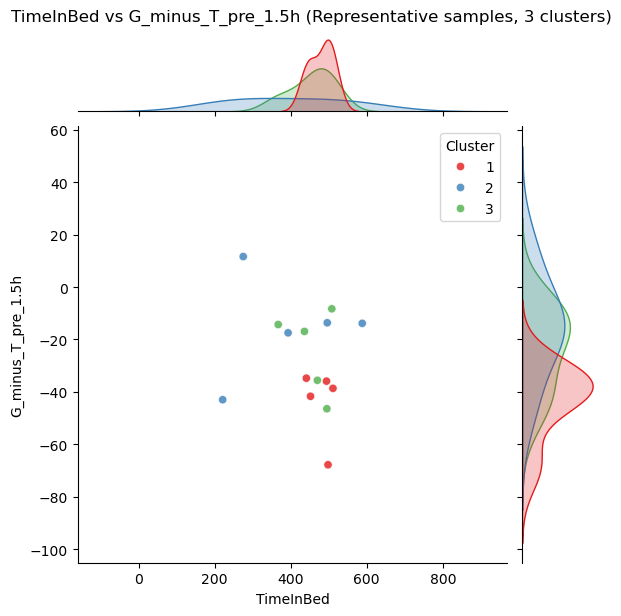

Plotting TimeInBed vs hungry


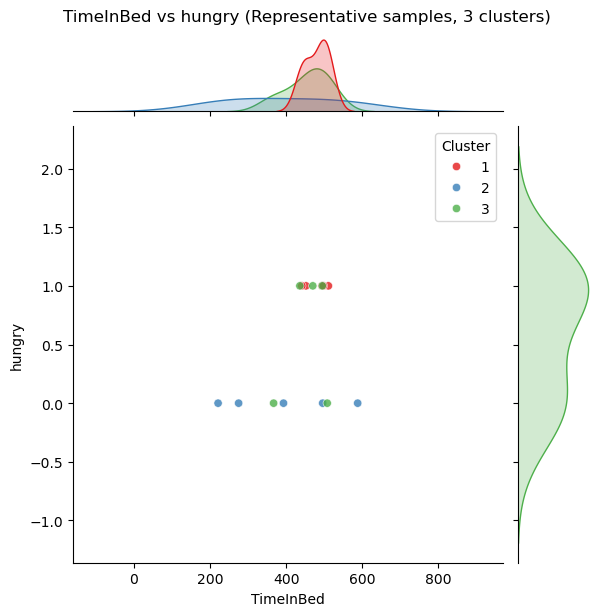

Plotting mean_intensity_1h vs hungry_within


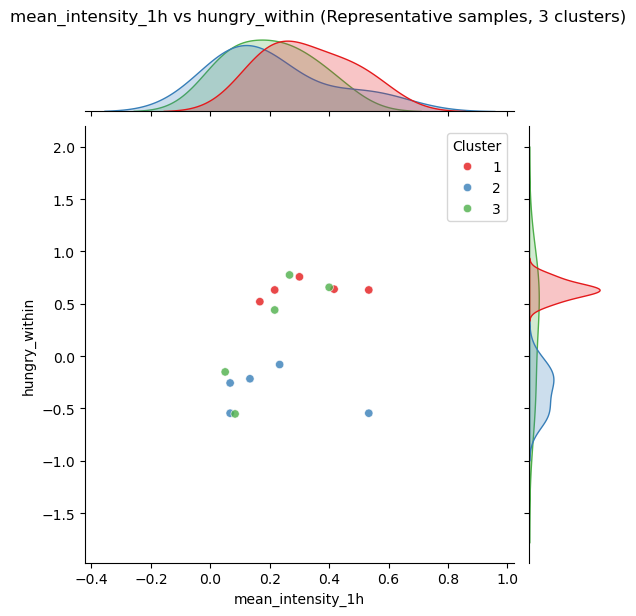

Plotting mean_intensity_1h vs How_tired


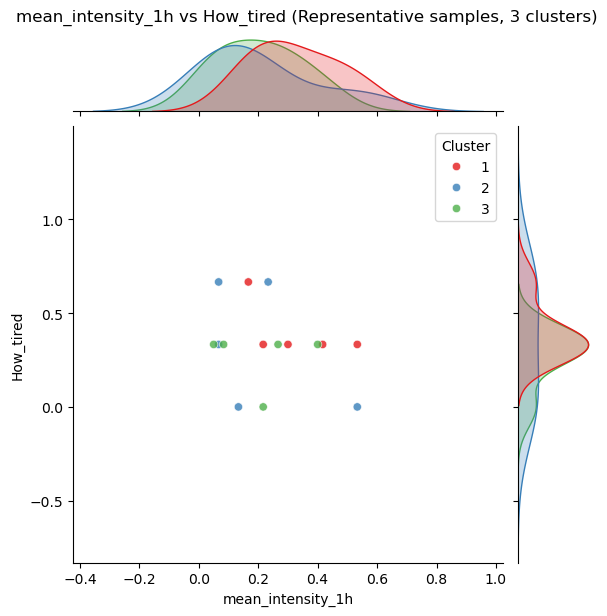

Plotting mean_intensity_1h vs G_minus_T_pre_1.5h


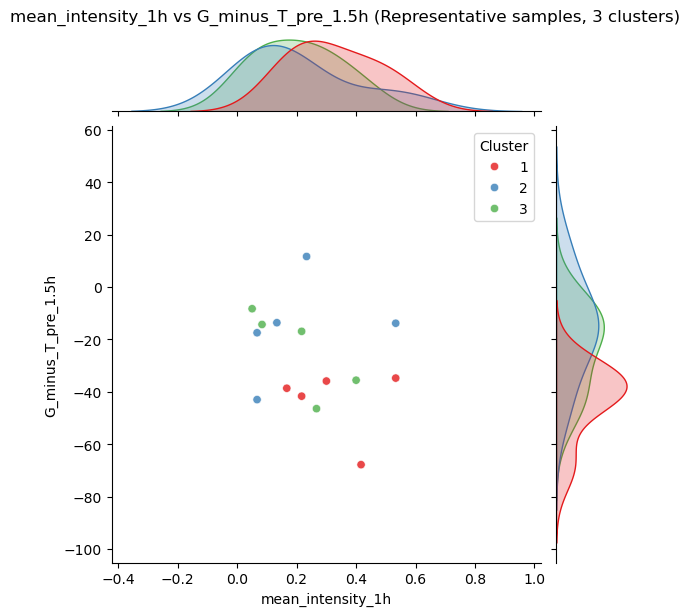

Plotting mean_intensity_1h vs hungry


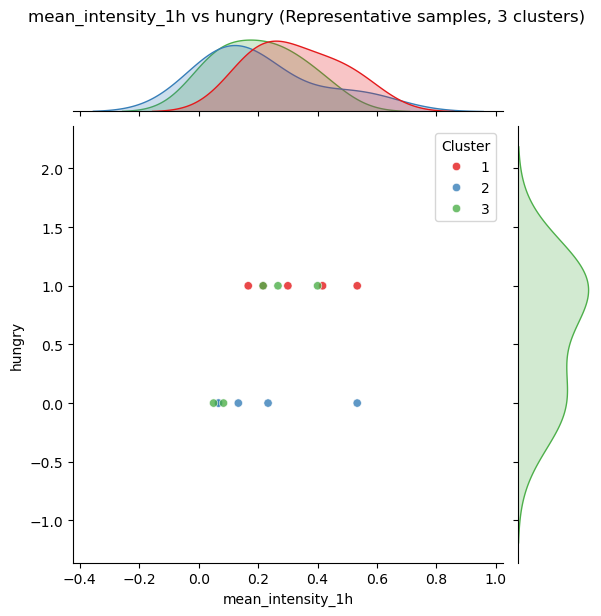

Plotting hungry_within vs How_tired


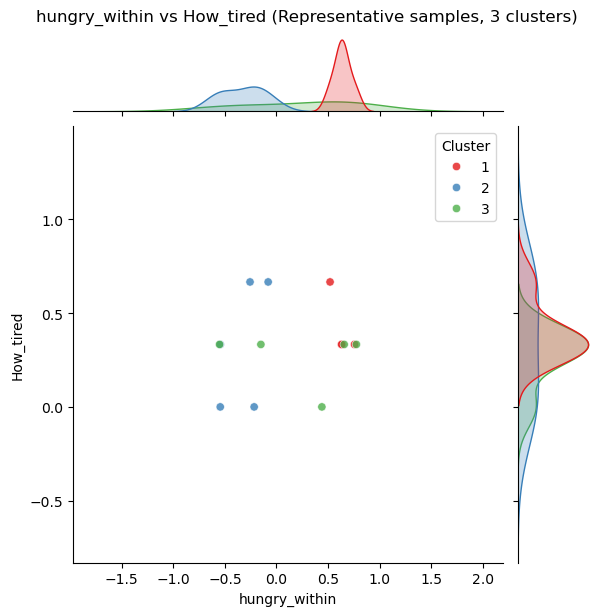

Plotting hungry_within vs G_minus_T_pre_1.5h


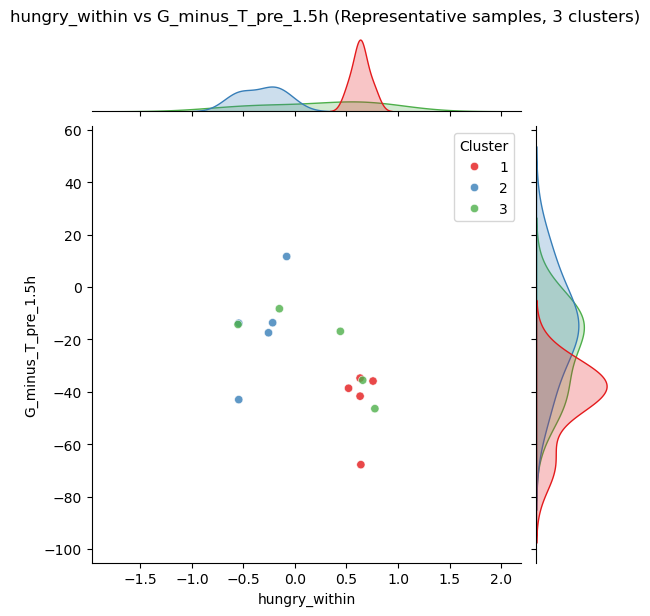

Plotting hungry_within vs hungry


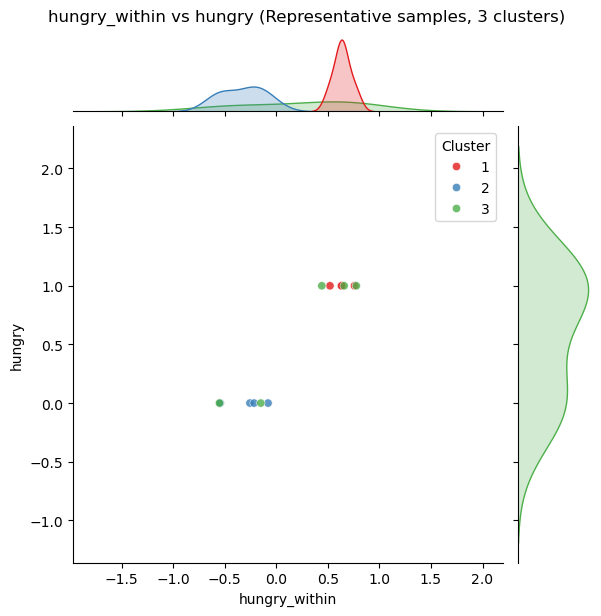

Plotting How_tired vs G_minus_T_pre_1.5h


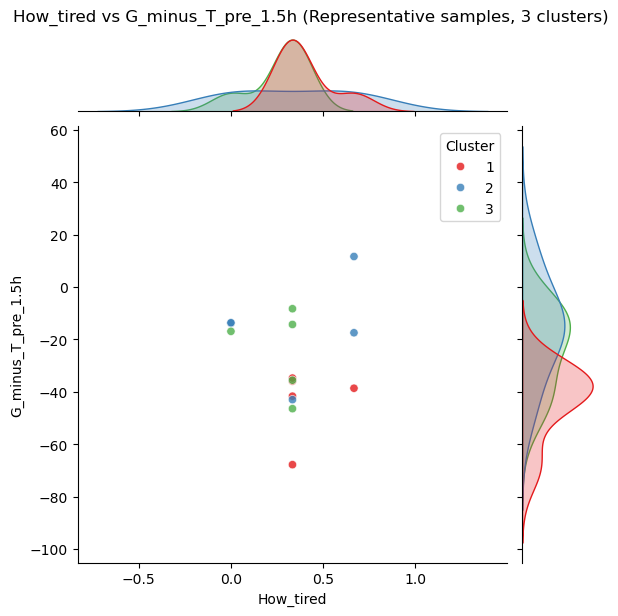

Plotting How_tired vs hungry


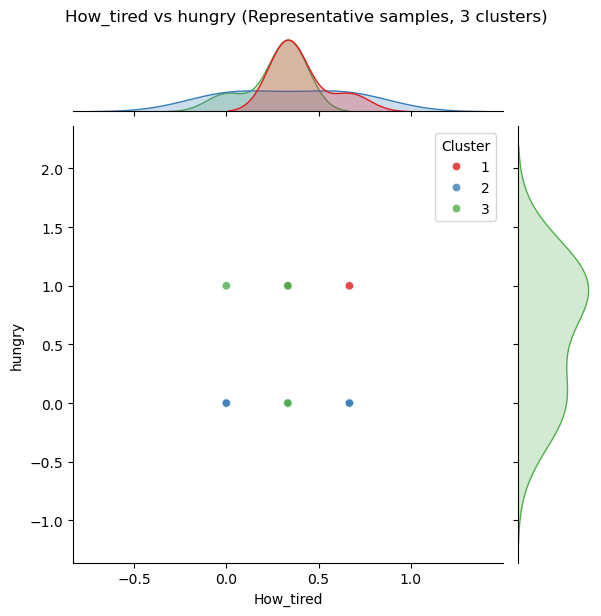

Plotting G_minus_T_pre_1.5h vs hungry


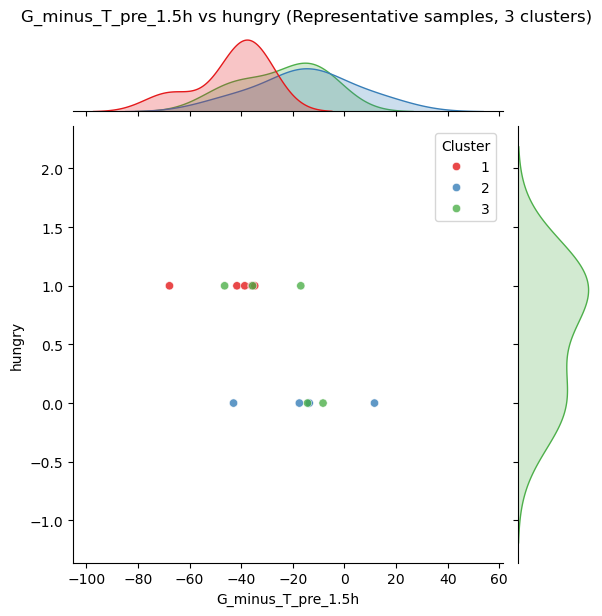

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# === 1) Collect 5 central samples per cluster ===
df_representatives = []
for cl, idxs in central_indices.items():
    temp = df_alerts_raw.iloc[idxs].copy()
    temp["Cluster"] = cl
    df_representatives.append(temp)
df_representatives = pd.concat(df_representatives, ignore_index=True)

# === 2) Union of top features across clusters ===
all_top_feats = list(set(sum(top_feats.values(), [])))

# === 3) Pairwise jointplots for top features ===
for f1, f2 in itertools.combinations(all_top_feats, 2):
    print(f"Plotting {f1} vs {f2}")
    g = sns.jointplot(
        data=df_representatives,
        x=f1, y=f2,
        hue="Cluster",
        palette="Set1",
        alpha=0.8,
        kind="scatter",                  # force scatter plot
        marginal_kws=dict(common_norm=False, fill=True)
    )
    g.fig.suptitle(f"{f1} vs {f2} (Representative samples, 3 clusters)", y=1.02)
    plt.show()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



=== Cluster 1 representative samples ===
Sample index: 578


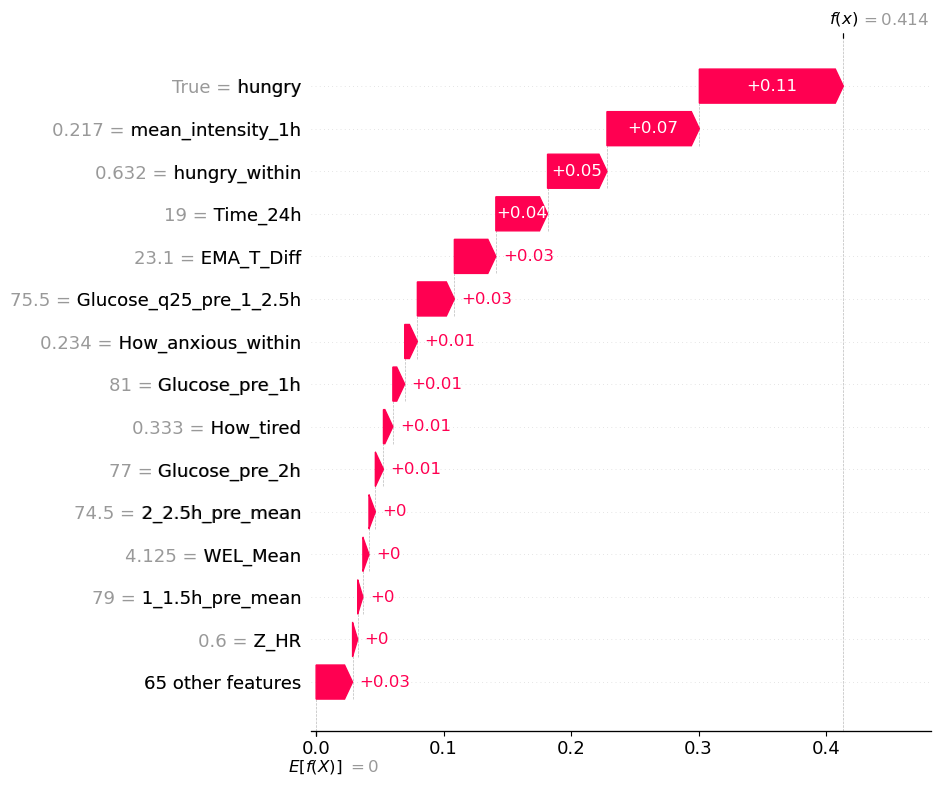

Sample index: 241


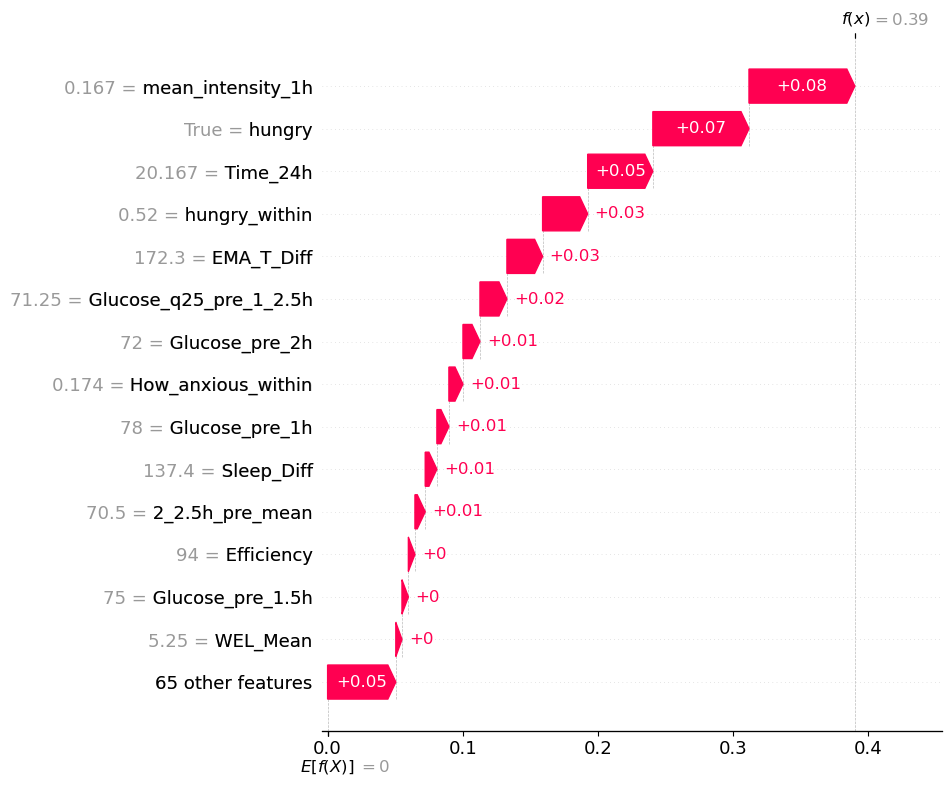

Sample index: 497


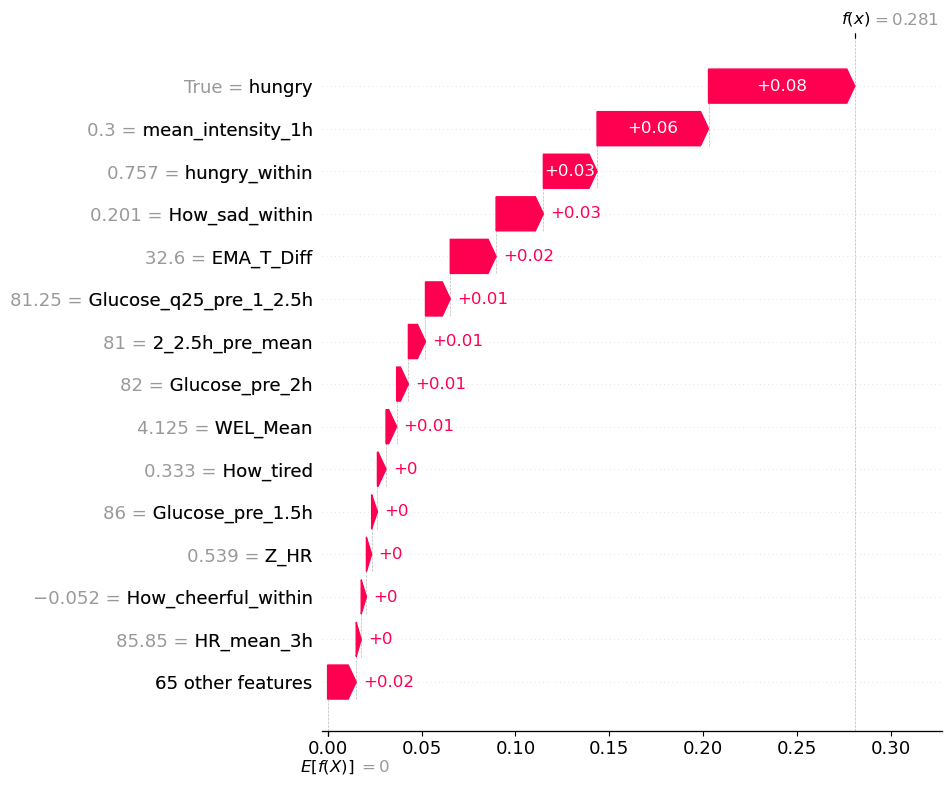

Sample index: 105


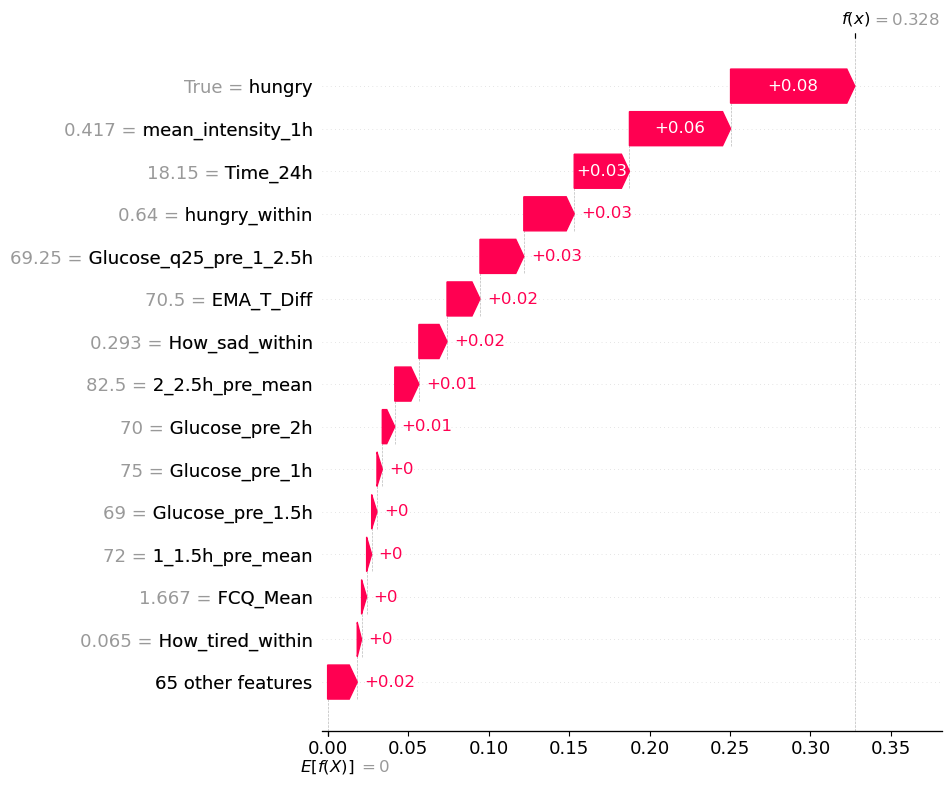

Sample index: 569


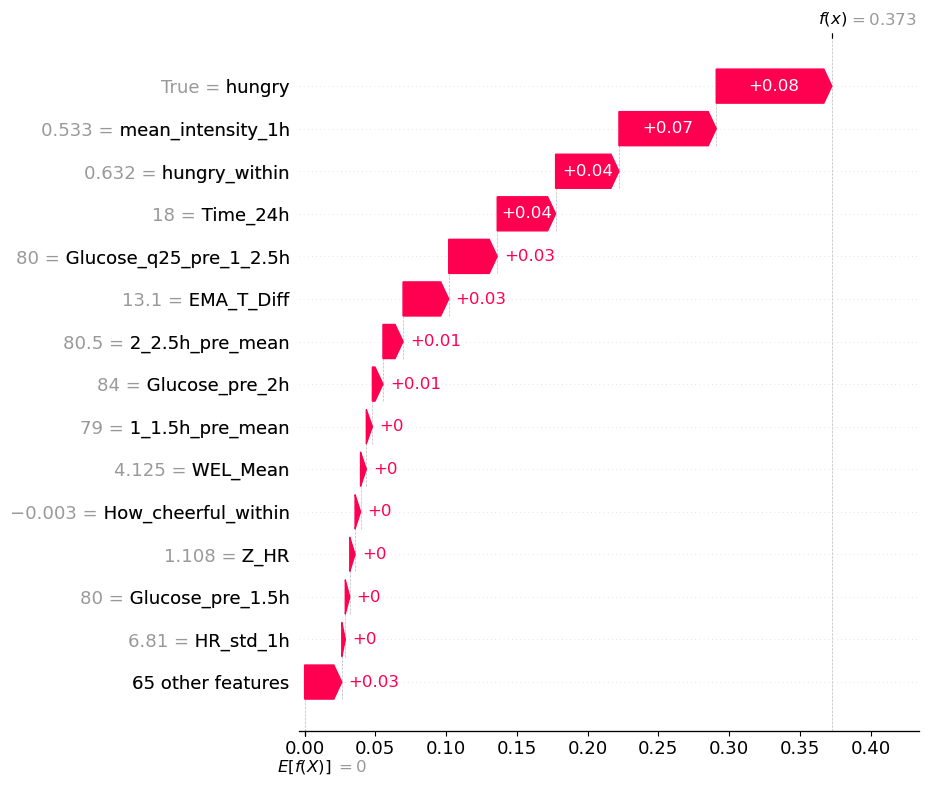


=== Cluster 2 representative samples ===
Sample index: 83


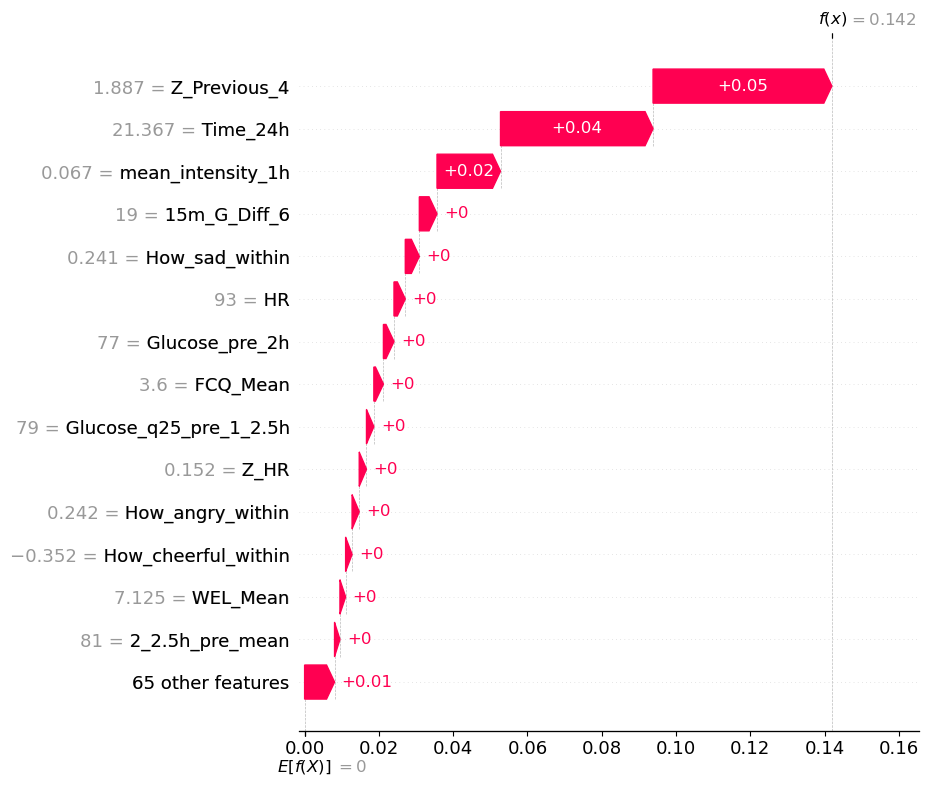

Sample index: 534


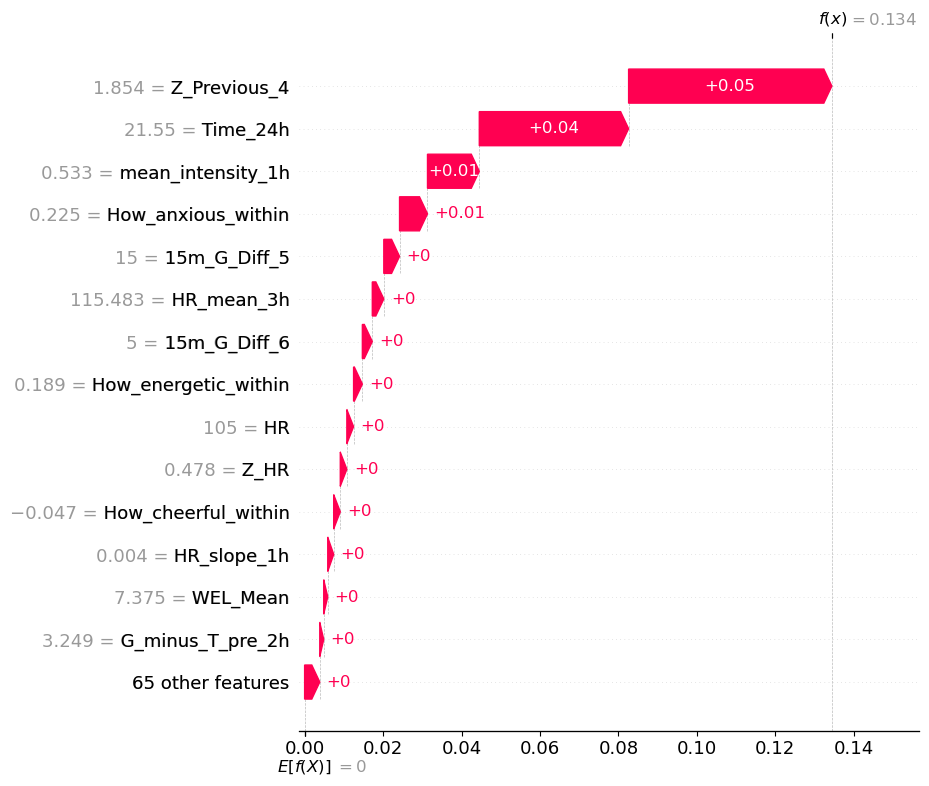

Sample index: 426


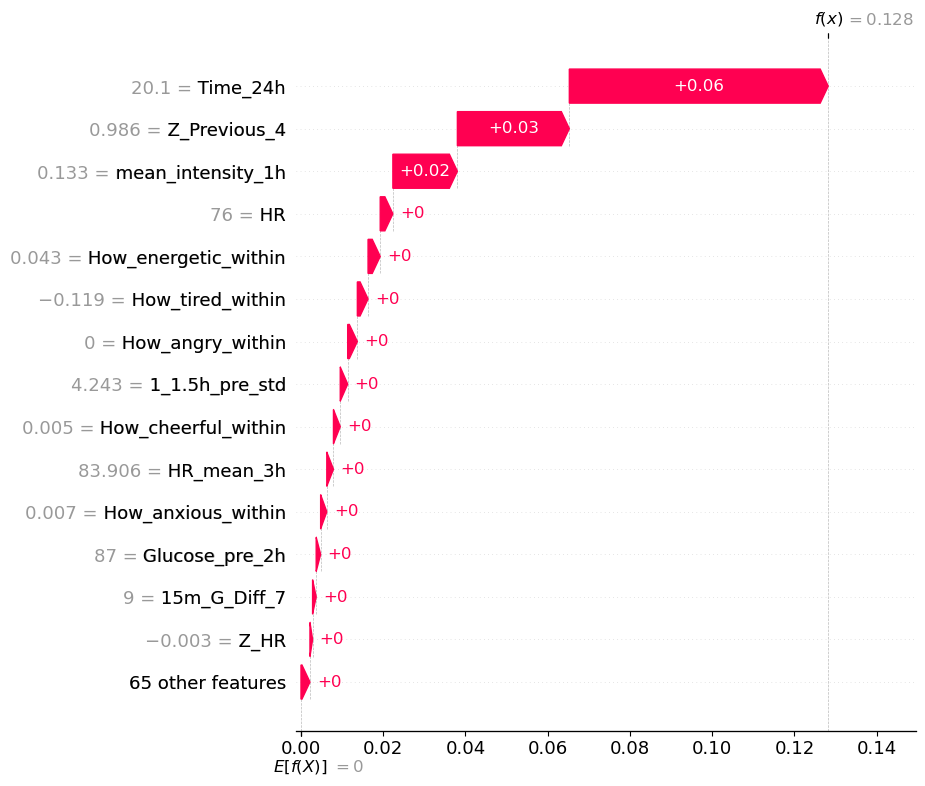

Sample index: 531


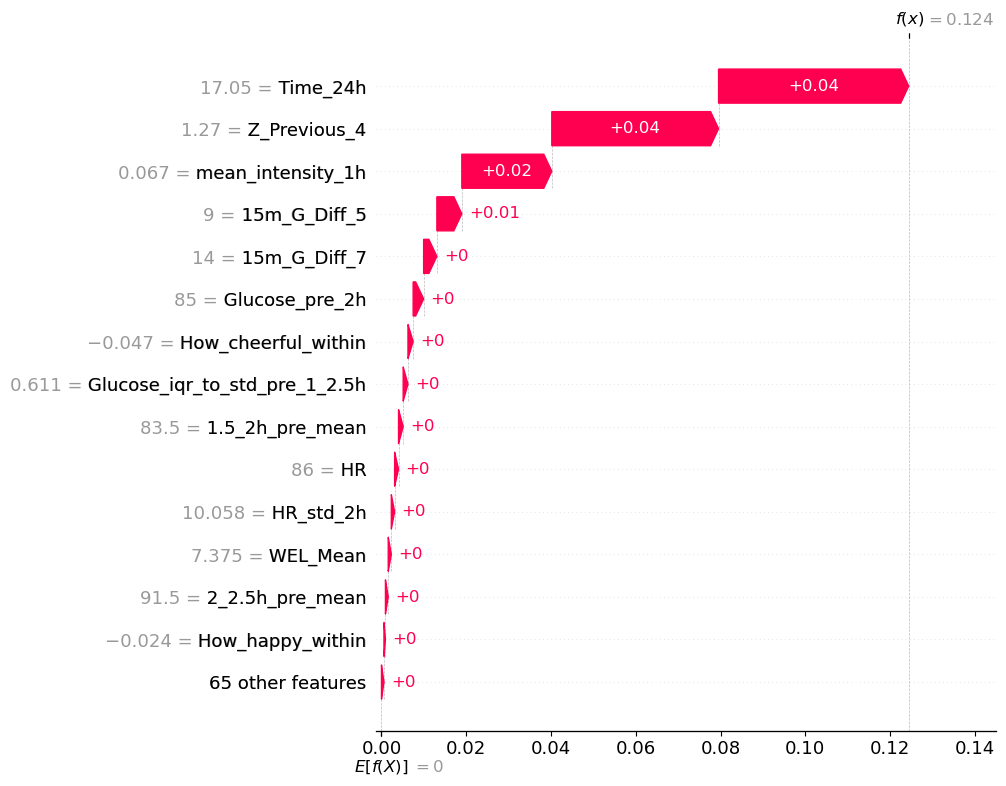

Sample index: 138


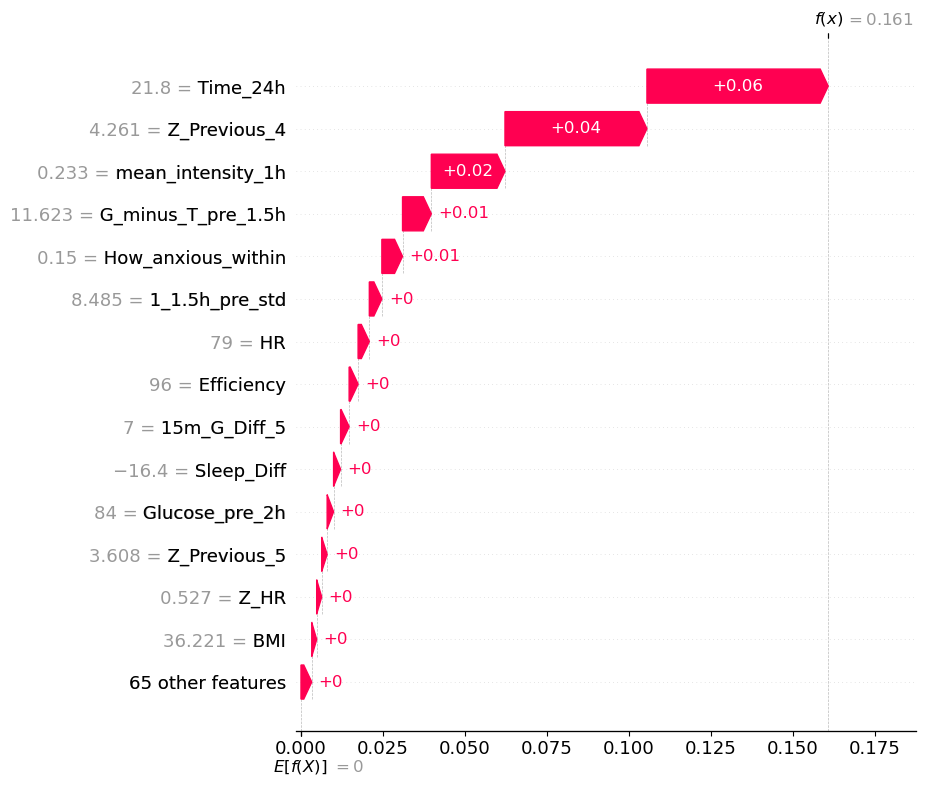


=== Cluster 3 representative samples ===
Sample index: 316


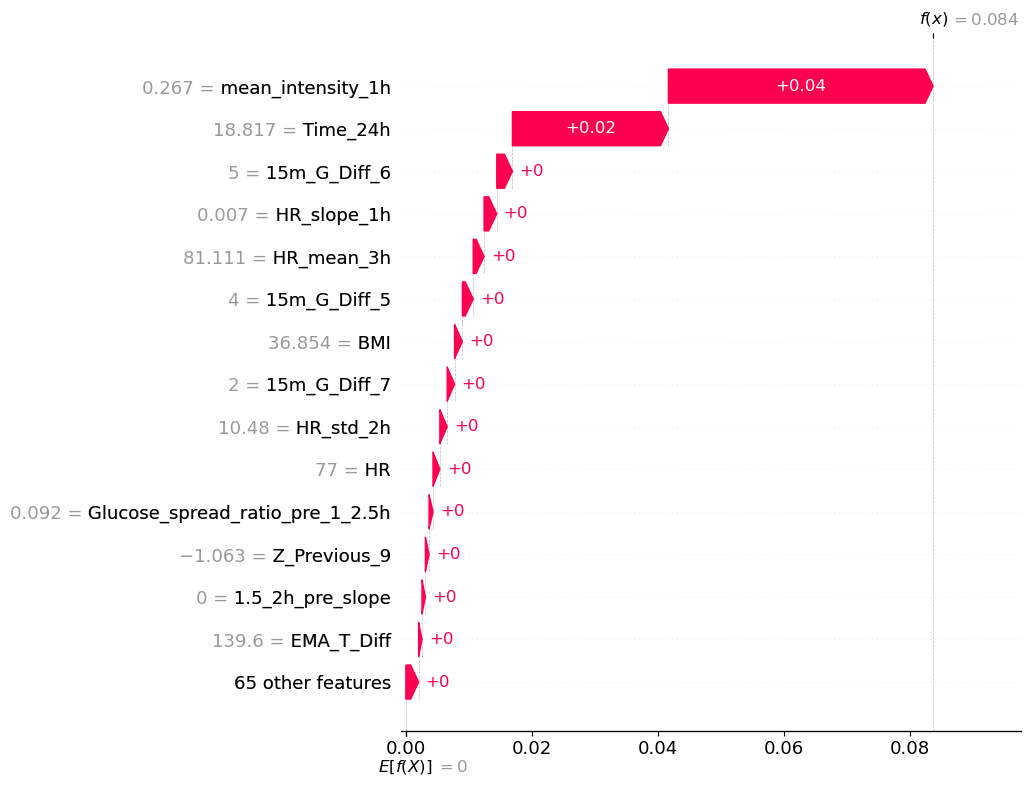

Sample index: 352


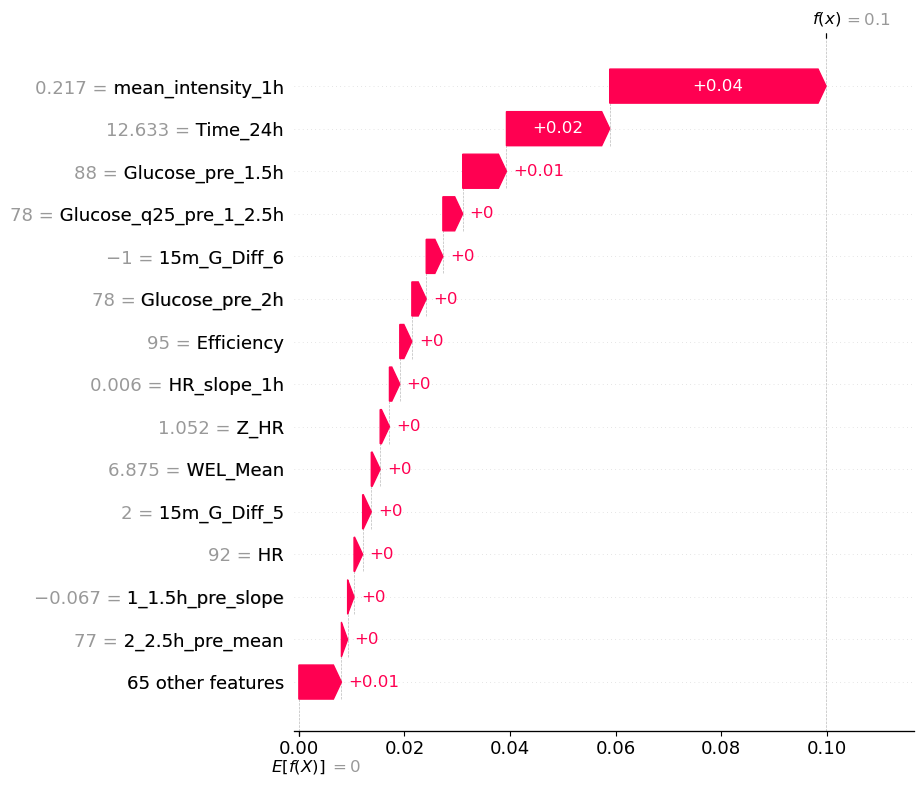

Sample index: 161


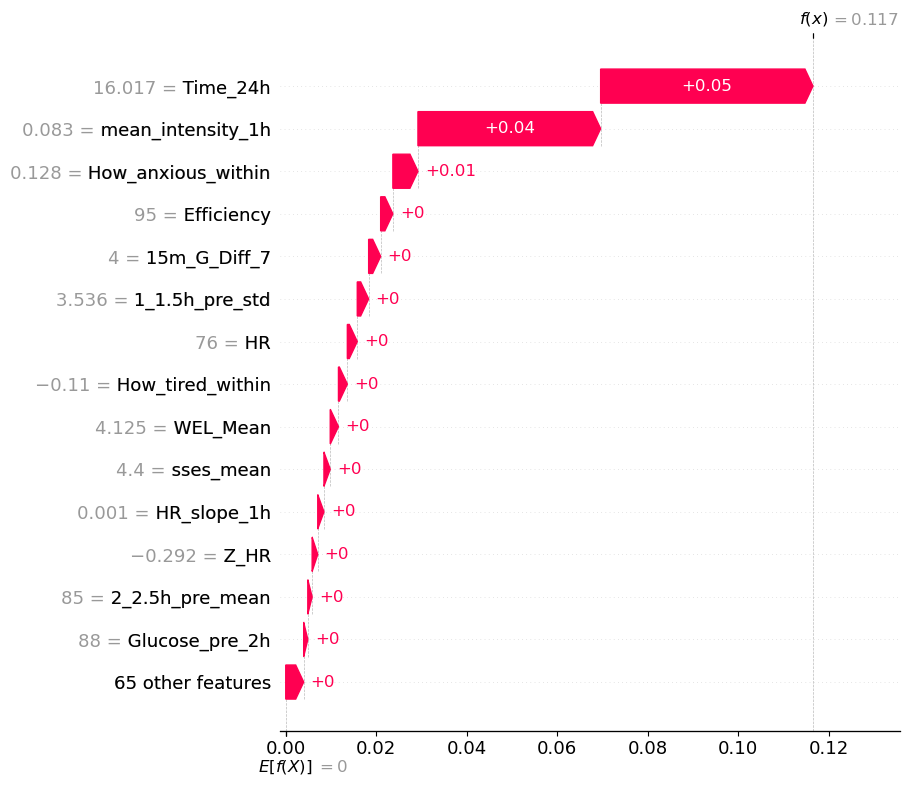

Sample index: 186


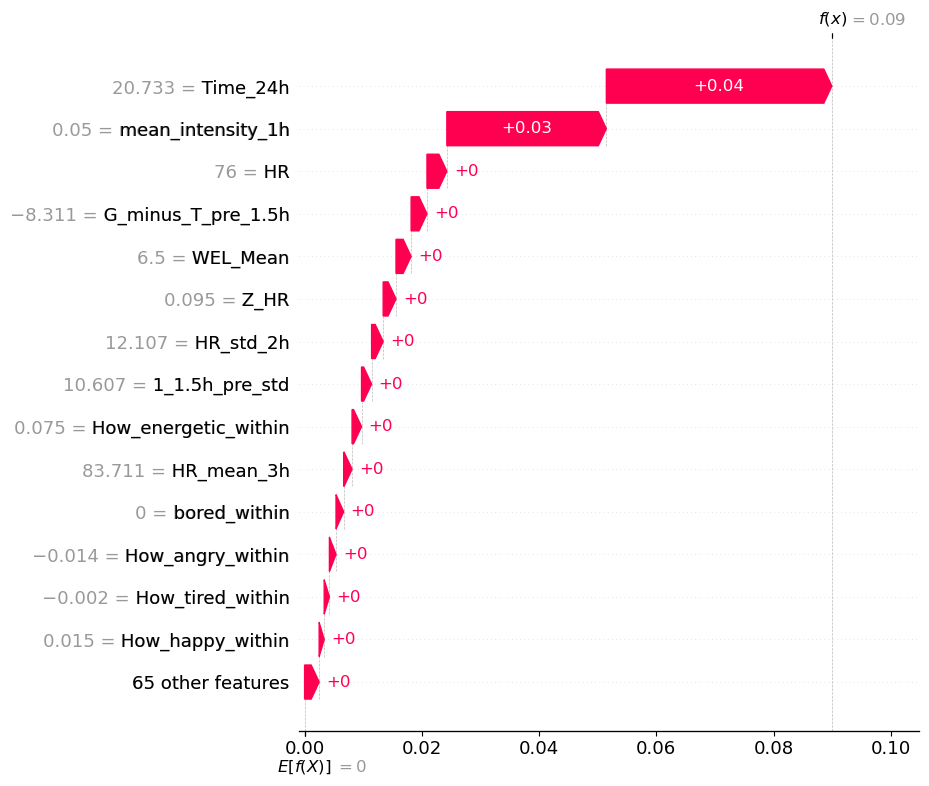

Sample index: 629


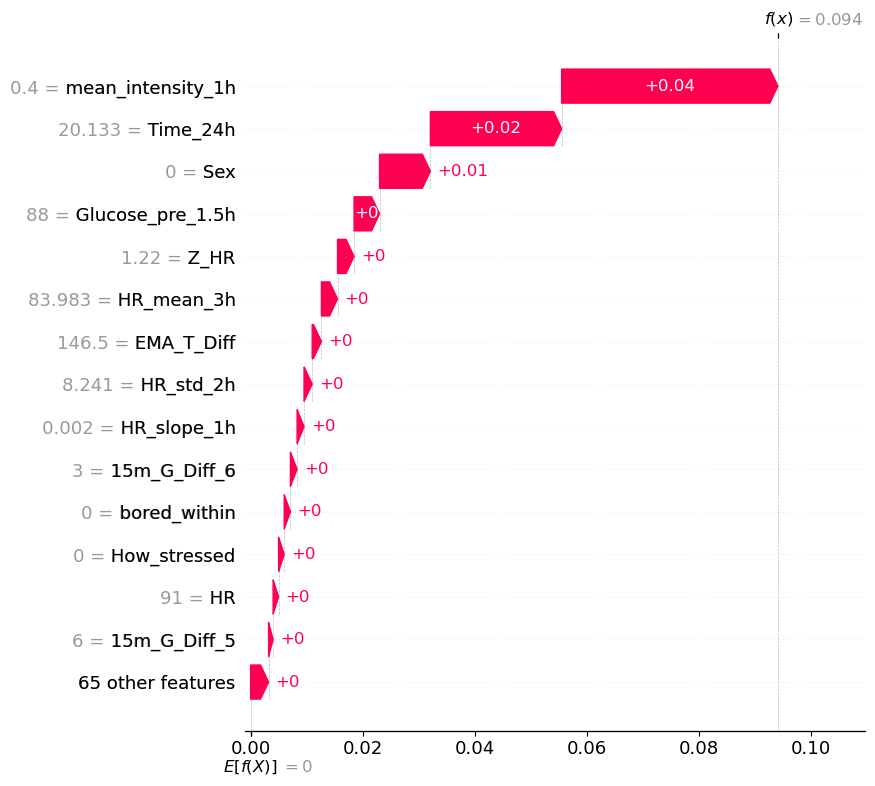

In [79]:
import shap
import matplotlib.pyplot as plt

# === 1) Prepare SHAP values (positive-only) ===
# shap_pos_clipped already has positive-only SHAP values (negatives → 0)
shap_values_pos = shap_pos_clipped

# === 2) Loop through clusters and representative indices ===
for cl, idxs in central_indices.items():
    print(f"\n=== Cluster {cl} representative samples ===")
    
    for i in idxs:
        print(f"Sample index: {i}")
        shap_values_sample = shap_values_pos[i]
        feature_values = df_alerts_raw.iloc[i][FEATURES]

        # === 3) Build SHAP explanation object for waterfall plot ===
        expl = shap.Explanation(
            values=shap_values_sample,
            base_values=0,                        # baseline
            data=feature_values.values,
            feature_names=FEATURES
        )

        # === 4) Plot waterfall (positive SHAP only) ===
        shap.plots.waterfall(expl, max_display=15, show=True)
        plt.show()
